 - The first step is to read in the original data, the transformed data, and the residuals. 
 - We will predict the scaled, transformed data and the scaled residuals


In [1]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
resid_file = 'environmental_residuals.txt'
txm_file = 'Transformed_WQVars_Hab_and_aDiv.txt'
orig_file = 'merged_paired_water_quality_data.txt'

resid_data <- as.data.frame(scale(read.delim(paste(data_dir, resid_file, sep="/"), row.names=1)))
txm_data <- read.delim(paste(data_dir, txm_file, sep="/"), row.names=1)
orig_data <- read.delim(paste(data_dir, orig_file, sep="/"), row.names=1)



  (-1,-0.5] (-0.5,0.25]  (0.25,0.5]  (0.5,0.85] (0.85,1.05] 
         49          28          44          52          63 

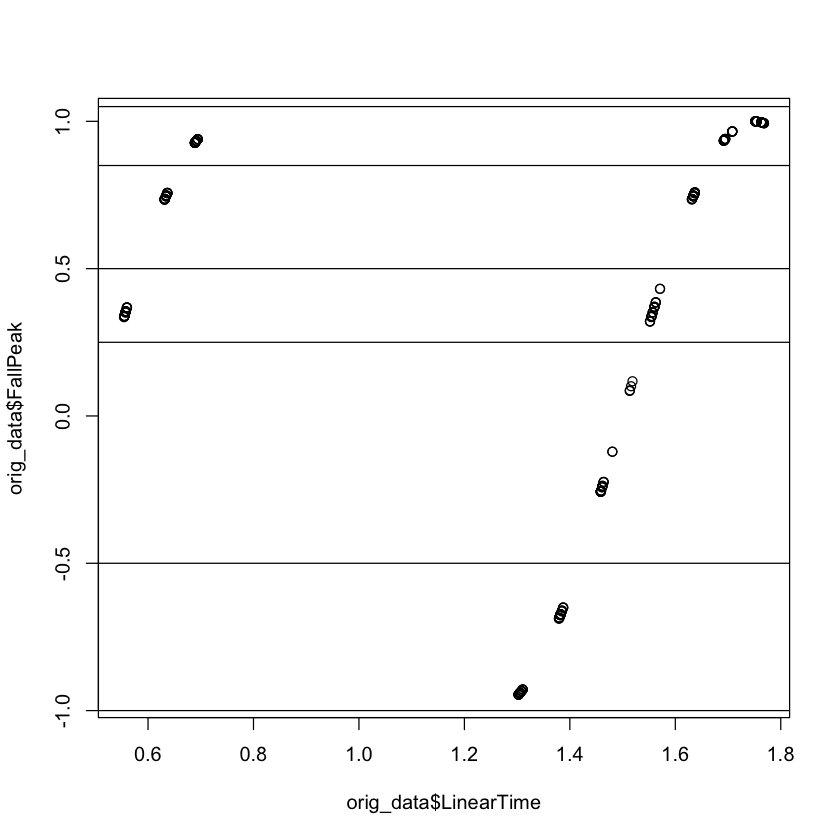

In [2]:
plot(orig_data$LinearTime, orig_data$FallPeak)
abline(h=c(1.05, 0.85, 0.5, 0.25, -0.5, -1))
table(cut(orig_data$FallPeak, c(1.05, 0.85, 0.5, 0.25, -0.5, -1)))

 - We will use the StatName and the binned seasonality data to create all possible combinations of time and location
 - We can pair each time x place with its opposite, because the response formed will be the same, with the 1s and 0s switched

Create all possible times and places

In [3]:
orig_data$seasonality = cut(orig_data$FallPeak, c(1.05, 0.85, 0.5, 0.25, -0.5, -1))
orig_data$seasonality = factor(as.integer(orig_data$seasonality))
table(orig_data$seasonality)

sample_times = base::sort(unique(orig_data$seasonality))

times_ = matrix(nrow = 5000, ncol = length(sample_times))
colnames(times_) <- paste('T', 1:length(sample_times), sep=".")
rownames(times_) <- paste('time', 1:5000, sep=".")

counter = 0
for (grp_size in 1:length(sample_times)){
    print(grp_size)
    grps = t(combn(sample_times, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        times_[counter,grps[row_n,]] = 1
    }
}

times_[is.na(times_)] = 0
times_ = times_[-which(rowSums(times_) == 0),]
dim(times_)

places = matrix(nrow = 5000, ncol = length(unique(txm_data$StatName)))
colnames(places) <- paste('P', 1:length(unique(txm_data$StatName)), sep=".")
rownames(places) <- paste('place', 1:5000, sep=".")


station_grps = base::sort(unique(txm_data$StatName))
counter = 0
for (grp_size in station_grps){
    print(grp_size)
    grps = t(combn(station_grps, grp_size))
    print(dim(grps))
    for (row_n in 1:dim(grps)[1]){
        counter = counter + 1
        places[counter,grps[row_n,]] = 1
    }
}

places[is.na(places)] = 0
places = places[-which(rowSums(places) == 0),]
dim(places)

times_places = matrix(nrow=nrow(places)*nrow(times_), 
                      ncol=ncol(places)+ncol(times_))

colnames(times_places) <- c(colnames(places), colnames(times_))
combo_rn = c()
combo_counter = 1
for (p_r in rownames(places)){
    for (t_r in rownames(times_)){
        combo_rn = c(combo_rn, paste(p_r, t_r, sep="_"))
        times_places[combo_counter, colnames(places)] = places[p_r,]
        times_places[combo_counter, colnames(times_)] = times_[t_r,]
        combo_counter = combo_counter + 1
    }
}
rownames(times_places) <- combo_rn
dim(times_places)
dim(unique(times_places))
old_names <- colnames(times_places)
times_places = cbind(times_places, apply(times_places, 1, paste, collapse=""), 
                     apply(abs(times_places - 1) , 1, paste, collapse=""))

colnames(times_places) <- c(old_names, 'binstring', 'opp.binstring')
head(times_places)


 1  2  3  4  5 
49 28 44 52 63 

[1] 1
[1] 5 1
[1] 2
[1] 10  2
[1] 3
[1] 10  3
[1] 4
[1] 5 4
[1] 5
[1] 1 5


[1] 31  5

[1] 1
[1] 7 1
[1] 2
[1] 21  2
[1] 3
[1] 35  3
[1] 4
[1] 35  4
[1] 5
[1] 21  5
[1] 6
[1] 7 6
[1] 7
[1] 1 7


[1] 127   7

[1] 3937   12

[1] 3937   12

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011
place.1_time.4,1,0,0,0,0,0,0,0,0,0,1,0,100000000010,011111111101
place.1_time.5,1,0,0,0,0,0,0,0,0,0,0,1,100000000001,011111111110
place.1_time.6,1,0,0,0,0,0,0,1,1,0,0,0,100000011000,011111100111


In [4]:
pair_list = list()
for (idx in 1:nrow(times_places)){
    t_p = rownames(times_places)[idx]
    animus = times_places[t_p, 'binstring']
    anima = times_places[, 'opp.binstring'] == animus
    if (sum(anima) > 0){
        p_t = names(which(anima))[1]
        doublet = sort(c(t_p, p_t))
        if (doublet[2] == t_p){
            pair_list[[idx]] = NA
        } else {
            pair_list[[idx]] = doublet[2]
        }
    } else {
        pair_list[[idx]] = 'unique'
    }
}

times_places = cbind(times_places, unlist(pair_list))
colnames(times_places)[colnames(times_places) == ''] <- 'setting_match'
length(which(times_places[,'setting_match'] == 'unique'))
sum(is.na(times_places[,'setting_match']))
head(times_places, 3)

[1] 157

[1] 1890

,P.1,P.2,P.3,P.4,P.5,P.6,P.7,T.1,T.2,T.3,T.4,T.5,binstring,opp.binstring,setting_match
place.1_time.1,1,0,0,0,0,0,0,1,0,0,0,0,100000010000,011111101111,place.126_time.30
place.1_time.2,1,0,0,0,0,0,0,0,1,0,0,0,100000001000,011111110111,place.126_time.29
place.1_time.3,1,0,0,0,0,0,0,0,0,1,0,0,100000000100,011111111011,place.126_time.28


Here we take the columns that aren't NA from the above `time_place` object and create a matrix of binary responses. We also filter out any time/place combinations that have fewer than 12 supporting samples. This is because of our need to split the data into test/train sets (by a 3:1 ratio) to evaluate the model & the minimum of 8 samples per factor level for logisitc ridge regression. 

In [6]:
statN = length(unique(txm_data$StatName))
seasN = length(unique(orig_data$seasonality))
response_set = matrix(0, ncol=nrow(times_places), nrow=nrow(orig_data))
rownames(response_set) <- rownames(orig_data)
colnames(response_set) <- rownames(times_places)

for (t_p in rownames(times_places)){
    stat_bool = as.logical(as.integer(times_places[t_p,1:statN]))
    ssnlty_bool = as.logical(as.integer(times_places[t_p,(statN+1):(statN+seasN)]))
    accepted_statnames = (1:statN)[stat_bool]
    accepted_season = (1:seasN)[ssnlty_bool]
    ones_ = (orig_data$seasonality %in% accepted_season) & (txm_data$StatName %in% accepted_statnames)
    response_set[which(ones_), t_p] = 1
}
dim(response_set)
response_setx = response_set[,(colSums(response_set) > 12) & (colSums(response_set) < 224)]
dim(response_setx)
table(colSums(response_setx))

[1]  236 3937

[1]  236 3756


 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 
 24  37  38  37  28  43  44  36  39  38  39  48  51  31  39  50  41  45  53  41 
 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52 
 39  50  49  37  42  56  51  37  46  50  43  40  37  49  47  42  45  44  31  56 
 53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72 
 46  34  34  45  33  52  40  38  30  47  33  36  38  41  31  36  38  37  31  41 
 73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92 
 31  26  25  36  38  27  27  31  33  22  25  28  23  25  35  18  26  24  27  21 
 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 
 25  19  14  24  23  18  25  17  16  19  18  12  16  18  18  15  12  15  16  16 
113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  8  12  18  14  10  11  11   8  14  14   6  11  10  12   5   6  10   5  12   8 
133 134 135 136 137 138 139

Here's where we read in the abundance data, create a permuted copy, and  create a place for the coefficients and run summary data

In [7]:
library(vegan)

rar_df = read.delim('../data/otu_tables/final_rarefied_table.tsv', row.names=1, sep="\t")[rownames(orig_data),]
rar_df = rar_df[which(rowSums(rar_df) > 0), which(colSums(rar_df) > 0)]
ra_rar_df = ((rar_df / rowSums(rar_df))*1e6)
dim(ra_rar_df)
int_rar_df = apply(apply(ra_rar_df, MAR=1, FUN=round), MAR=1, FUN=as.integer)
dim(int_rar_df)

coeff_cols = c('(Intercept)', colnames(ra_rar_df), 'coef.pos.n', 
               'coef.mean.n', 'ppv', 'npv', 'acc')
coeff_rows = colnames(response_setx)

fit_results = matrix(NA, ncol=length(coeff_cols), nrow=length(coeff_rows))
colnames(fit_results) <- coeff_cols
rownames(fit_results) <- coeff_rows

permutation2_results = fit_results
dim(permutation2_results)


Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5


[1]  236 1432

[1]  236 1432

[1] 3756 1438

In [8]:
pfile2 = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/permuted_tablev2.txt'

if (file.exists(pfile2)) {
    perm_table2 = read.delim(pfile2, row.names=1)
    print('table 2 read')
    print(dim(perm_table2))
} else {
    perm_df2 = permatswap(int_rar_df, times=1)
    perm_table2 = perm_df2$perm[[1]]
    write.table(perm_table2, file=pfile2, sep="\t")
    print("table 2 written")
    print(dim(perm_table2))
}

[1] "table 2 read"
[1]  236 1432


In [11]:
library(glmnet)
library(caret)
library(doParallel)

registerDoParallel(2)

seed.counter = 0
predictor_sets = list('real'=log(ra_rar_df + 1), 'permat'=log(perm_table2 + 1 ))
results_tables = list('real'=fit_results, 'permat'=permutation2_results)

for (t_p in colnames(response_setx)) {
    # pull response
    response.j = factor(as.integer(response_setx[,t_p]))
    hits.j = which(response.j == 1)
    misses.j = which(response.j == 0)
    
    for (pred_name in names(predictor_sets)) {
        # pull & convert predictive matrix
        predictors.j = as.matrix(predictor_sets[[pred_name]])

        # set seed
        seed.counter = seed.counter + 1
        
        for (split.i in 1:5) {
            set.seed(seed.counter+split.i)
            # ensure splits include a minimum of 8 positive & negative results
            hits.ji = sample(hits.j, length(hits.j)*.75, rep=F)
            misses.ji = sample(misses.j, length(misses.j)*.75, rep=F)
            trainIxs = base::sort(c(hits.ji, misses.ji))
            predictors.ij = predictors.j[trainIxs,]
            response.ij = response.j[trainIxs]
            # pull out the test set by missing rownames
            testIxs = which(!(rownames(predictors.j) %in% rownames(predictors.ij)))
            predictors.ji = predictors.j[testIxs,]
            response.ji = response.j[testIxs]
            # fit model
            cvfit.ij <- cv.glmnet(x=predictors.ij, y=response.ij, family = "binomial", type.measure = "class",
                                 nfolds = 5, parallel = T)
            # predict on held out data
            fitted_values.ji = predict(cvfit.ij, newx=predictors.ji, type = "class", s = 'lambda.min')
            fitted_values.ji = factor(as.integer(as.numeric(fitted_values.ji)))
            # scores 1, 2, and 3 (it alwys assumes 'FALSE' and 0 are the positive class)
            cm.ij = confusionMatrix(factor(fitted_values.ji, levels=c(0, 1)), 
                                    factor(response.ji, levels=c(0, 1)), positive='1')
            coef.ij = as.matrix(coef(cvfit.ij, s = "lambda.min"))
            colnames(coef.ij) <- c(split.i)
            stats.ij = matrix(c(cm.ij$overall['Accuracy'], cm.ij$byClass['Pos Pred Value'], 
                                cm.ij$byClass['Neg Pred Value']), ncol=1, nrow=3, 
                              dimnames = list(c('acc', 'ppv', 'npv'), c(split.i)))
            if (split.i == 1) {
                fold.scores = rbind(coef.ij, stats.ij)
            } else {
                fold.scores = cbind(fold.scores, rbind(coef.ij, stats.ij))
            }
        }
        # average folds
        folded.scores = apply(fold.scores, 1, function(x) {mean(x, na.rm=T)})
        # pull out results recepticle 
        results.j = results_tables[[pred_name]]
        # add these scores
        results.j[t_p, 'acc'] = folded.scores['acc']
        results.j[t_p, 'ppv'] = folded.scores['ppv']
        results.j[t_p, 'npv'] = folded.scores['npv']
        # coefficients without score columns
        all_coeffs = folded.scores[1:(length(folded.scores)-3)]
        column_matcher = colnames(results.j)[which(colnames(results.j) %in% names(all_coeffs))]
        results.j[t_p, column_matcher] = folded.scores[column_matcher]
        # summary stats for just OTU coefficients
        just_otu_coeffs = folded.scores[2:(length(folded.scores)-3)]
        results.j[t_p, 'coef.pos.n'] = sum(just_otu_coeffs > 0)
        results.j[t_p, 'coef.mean.n'] = mean(just_otu_coeffs[just_otu_coeffs > 0])
        #repack results
        results_tables[[pred_name]] = results.j
        
        progpct = round(((seed.counter / (ncol(response_setx)*length(predictor_sets)))*100), 1)
        print(paste(t_p, pred_name, round(results.j[t_p, 'acc']*100, 1), progpct, collapse=", "))
        flush.console()
    }
}

stopImplicitCluster()

Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:vegan’:

    tolerance



[1] "place.1_time.14 real 95.7 0"
[1] "place.1_time.14 permat 93.3 0"
[1] "place.1_time.15 real 97.3 0"
[1] "place.1_time.15 permat 93.3 0.1"
[1] "place.1_time.16 real 94.3 0.1"
[1] "place.1_time.16 permat 93.3 0.1"
[1] "place.1_time.17 real 93.3 0.1"
[1] "place.1_time.17 permat 93.3 0.1"
[1] "place.1_time.18 real 95.3 0.1"
[1] "place.1_time.18 permat 93.3 0.1"
[1] "place.1_time.19 real 96.9 0.1"
[1] "place.1_time.19 permat 93.2 0.2"
[1] "place.1_time.20 real 94.7 0.2"
[1] "place.1_time.20 permat 91.7 0.2"
[1] "place.1_time.21 real 96 0.2"
[1] "place.1_time.21 permat 91.7 0.2"
[1] "place.1_time.22 real 97 0.2"
[1] "place.1_time.22 permat 93.3 0.2"
[1] "place.1_time.23 real 94.6 0.3"
[1] "place.1_time.23 permat 93.2 0.3"
[1] "place.1_time.24 real 94.2 0.3"
[1] "place.1_time.24 permat 93.2 0.3"
[1] "place.1_time.25 real 96.7 0.3"
[1] "place.1_time.25 permat 91.7 0.3"
[1] "place.1_time.26 real 93.7 0.3"
[1] "place.1_time.26 permat 91.7 0.3"
[1] "place.1_time.27 real 94.6 0.4"
[1] "place.1

[1] "place.6_time.27 permat 80 3"
[1] "place.6_time.28 real 78.7 3"
[1] "place.6_time.28 permat 77.7 3.1"
[1] "place.6_time.29 real 80.3 3.1"
[1] "place.6_time.29 permat 75.3 3.1"
[1] "place.6_time.30 real 81.7 3.1"
[1] "place.6_time.30 permat 81.3 3.1"
[1] "place.6_time.31 real 78.3 3.1"
[1] "place.6_time.31 permat 74.3 3.1"
[1] "place.7_time.20 real 93 3.2"
[1] "place.7_time.20 permat 93.3 3.2"
[1] "place.7_time.21 real 94 3.2"
[1] "place.7_time.21 permat 93.3 3.2"
[1] "place.7_time.25 real 94.7 3.2"
[1] "place.7_time.25 permat 93.3 3.2"
[1] "place.7_time.26 real 93.7 3.2"
[1] "place.7_time.26 permat 93.3 3.2"
[1] "place.7_time.27 real 94.2 3.3"
[1] "place.7_time.27 permat 93.2 3.3"
[1] "place.7_time.28 real 94.2 3.3"
[1] "place.7_time.28 permat 93.2 3.3"
[1] "place.7_time.29 real 92 3.3"
[1] "place.7_time.29 permat 91.7 3.3"
[1] "place.7_time.30 real 93.2 3.3"
[1] "place.7_time.30 permat 93.2 3.4"
[1] "place.7_time.31 real 91.9 3.4"
[1] "place.7_time.31 permat 91.5 3.4"
[1] "place.8

[1] "place.11_time.22 real 82.7 6"
[1] "place.11_time.22 permat 81.7 6"
[1] "place.11_time.23 real 80.7 6.1"
[1] "place.11_time.23 permat 80 6.1"
[1] "place.11_time.24 real 78 6.1"
[1] "place.11_time.24 permat 80 6.1"
[1] "place.11_time.25 real 78.7 6.1"
[1] "place.11_time.25 permat 76.7 6.1"
[1] "place.11_time.26 real 78 6.1"
[1] "place.11_time.26 permat 74 6.2"
[1] "place.11_time.27 real 76 6.2"
[1] "place.11_time.27 permat 73.3 6.2"
[1] "place.11_time.28 real 77.7 6.2"
[1] "place.11_time.28 permat 73.3 6.2"
[1] "place.11_time.29 real 78 6.2"
[1] "place.11_time.29 permat 70.5 6.2"
[1] "place.11_time.30 real 78 6.2"
[1] "place.11_time.30 permat 73.3 6.3"
[1] "place.11_time.31 real 70.7 6.3"
[1] "place.11_time.31 permat 66.7 6.3"
[1] "place.12_time.1 real 92.5 6.3"
[1] "place.12_time.1 permat 91.5 6.3"
[1] "place.12_time.3 real 92.3 6.3"
[1] "place.12_time.3 permat 93.3 6.3"
[1] "place.12_time.4 real 92 6.3"
[1] "place.12_time.4 permat 91.7 6.4"
[1] "place.12_time.5 real 90 6.4"
[1] "p

[1] "place.15_time.21 real 86.4 9"
[1] "place.15_time.21 permat 84.7 9"
[1] "place.15_time.22 real 87 9"
[1] "place.15_time.22 permat 86.7 9"
[1] "place.15_time.23 real 88.3 9"
[1] "place.15_time.23 permat 87.7 9.1"
[1] "place.15_time.24 real 88.3 9.1"
[1] "place.15_time.24 permat 86.7 9.1"
[1] "place.15_time.25 real 86.1 9.1"
[1] "place.15_time.25 permat 83.7 9.1"
[1] "place.15_time.26 real 84 9.1"
[1] "place.15_time.26 permat 83.3 9.1"
[1] "place.15_time.27 real 83.3 9.1"
[1] "place.15_time.27 permat 83.3 9.2"
[1] "place.15_time.28 real 84 9.2"
[1] "place.15_time.28 permat 81.7 9.2"
[1] "place.15_time.29 real 80.3 9.2"
[1] "place.15_time.29 permat 80 9.2"
[1] "place.15_time.30 real 85.7 9.2"
[1] "place.15_time.30 permat 81.7 9.2"
[1] "place.15_time.31 real 78 9.3"
[1] "place.15_time.31 permat 78.3 9.3"
[1] "place.16_time.1 real 89 9.3"
[1] "place.16_time.1 permat 91.3 9.3"
[1] "place.16_time.3 real 93.2 9.3"
[1] "place.16_time.3 permat 93.2 9.3"
[1] "place.16_time.4 real 93.3 9.3"
[1

[1] "place.19_time.17 real 90 11.9"
[1] "place.19_time.17 permat 91.7 11.9"
[1] "place.19_time.18 real 90.8 11.9"
[1] "place.19_time.18 permat 89.8 11.9"
[1] "place.19_time.19 real 89.7 11.9"
[1] "place.19_time.19 permat 90 12"
[1] "place.19_time.20 real 89.7 12"
[1] "place.19_time.20 permat 88.3 12"
[1] "place.19_time.21 real 88.3 12"
[1] "place.19_time.21 permat 88.3 12"
[1] "place.19_time.22 real 89.7 12"
[1] "place.19_time.22 permat 89.3 12"
[1] "place.19_time.23 real 86.7 12"
[1] "place.19_time.23 permat 88.3 12.1"
[1] "place.19_time.24 real 88.3 12.1"
[1] "place.19_time.24 permat 88.3 12.1"
[1] "place.19_time.25 real 89.5 12.1"
[1] "place.19_time.25 permat 88.1 12.1"
[1] "place.19_time.26 real 86.1 12.1"
[1] "place.19_time.26 permat 88.1 12.1"
[1] "place.19_time.27 real 84.3 12.2"
[1] "place.19_time.27 permat 85 12.2"
[1] "place.19_time.28 real 87.3 12.2"
[1] "place.19_time.28 permat 86.7 12.2"
[1] "place.19_time.29 real 86.7 12.2"
[1] "place.19_time.29 permat 85 12.2"
[1] "place

[1] "place.23_time.9 real 86 14.8"
[1] "place.23_time.9 permat 86.7 14.8"
[1] "place.23_time.10 real 89.7 14.8"
[1] "place.23_time.10 permat 89.3 14.8"
[1] "place.23_time.11 real 91.5 14.8"
[1] "place.23_time.11 permat 91.5 14.8"
[1] "place.23_time.12 real 88.3 14.8"
[1] "place.23_time.12 permat 88.3 14.9"
[1] "place.23_time.13 real 87.7 14.9"
[1] "place.23_time.13 permat 88.3 14.9"
[1] "place.23_time.14 real 88.7 14.9"
[1] "place.23_time.14 permat 86.7 14.9"
[1] "place.23_time.15 real 87 14.9"
[1] "place.23_time.15 permat 86.7 14.9"
[1] "place.23_time.16 real 84.3 14.9"
[1] "place.23_time.16 permat 85 15"
[1] "place.23_time.17 real 85 15"
[1] "place.23_time.17 permat 85 15"
[1] "place.23_time.18 real 82.3 15"
[1] "place.23_time.18 permat 83.3 15"
[1] "place.23_time.19 real 82 15"
[1] "place.23_time.19 permat 83.3 15"
[1] "place.23_time.20 real 80.7 15.1"
[1] "place.23_time.20 permat 81.4 15.1"
[1] "place.23_time.21 real 81.7 15.1"
[1] "place.23_time.21 permat 81.7 15.1"
[1] "place.23_

[1] "place.27_time.4 permat 93.3 17.6"
[1] "place.27_time.5 real 90.8 17.6"
[1] "place.27_time.5 permat 91.5 17.7"
[1] "place.27_time.6 real 89.8 17.7"
[1] "place.27_time.6 permat 89.8 17.7"
[1] "place.27_time.7 real 86.7 17.7"
[1] "place.27_time.7 permat 86.7 17.7"
[1] "place.27_time.8 real 87 17.7"
[1] "place.27_time.8 permat 86.7 17.7"
[1] "place.27_time.9 real 84.7 17.7"
[1] "place.27_time.9 permat 85 17.8"
[1] "place.27_time.10 real 89.7 17.8"
[1] "place.27_time.10 permat 90 17.8"
[1] "place.27_time.11 real 90 17.8"
[1] "place.27_time.11 permat 90 17.8"
[1] "place.27_time.12 real 85.3 17.8"
[1] "place.27_time.12 permat 86.3 17.8"
[1] "place.27_time.13 real 87.8 17.9"
[1] "place.27_time.13 permat 88.1 17.9"
[1] "place.27_time.14 real 83.7 17.9"
[1] "place.27_time.14 permat 85 17.9"
[1] "place.27_time.15 real 86.7 17.9"
[1] "place.27_time.15 permat 85 17.9"
[1] "place.27_time.16 real 83.3 17.9"
[1] "place.27_time.16 permat 83.3 17.9"
[1] "place.27_time.17 real 83.3 18"
[1] "place.27

[1] "place.30_time.22 permat 81.4 20.5"
[1] "place.30_time.23 real 85.3 20.5"
[1] "place.30_time.23 permat 81.7 20.5"
[1] "place.30_time.24 real 89 20.5"
[1] "place.30_time.24 permat 80 20.6"
[1] "place.30_time.25 real 89 20.6"
[1] "place.30_time.25 permat 74.7 20.6"
[1] "place.30_time.26 real 88 20.6"
[1] "place.30_time.26 permat 75 20.6"
[1] "place.30_time.27 real 83.7 20.6"
[1] "place.30_time.27 permat 75 20.6"
[1] "place.30_time.28 real 84.7 20.6"
[1] "place.30_time.28 permat 72 20.7"
[1] "place.30_time.29 real 87 20.7"
[1] "place.30_time.29 permat 68.7 20.7"
[1] "place.30_time.30 real 88.3 20.7"
[1] "place.30_time.30 permat 73.3 20.7"
[1] "place.30_time.31 real 82.7 20.7"
[1] "place.30_time.31 permat 66.7 20.7"
[1] "place.31_time.1 real 92 20.8"
[1] "place.31_time.1 permat 90 20.8"
[1] "place.31_time.2 real 94 20.8"
[1] "place.31_time.2 permat 93.3 20.8"
[1] "place.31_time.3 real 91.3 20.8"
[1] "place.31_time.3 permat 90 20.8"
[1] "place.31_time.4 real 90.8 20.8"
[1] "place.31_tim

[1] "place.34_time.10 real 88.8 23.4"
[1] "place.34_time.10 permat 89.8 23.4"
[1] "place.34_time.11 real 90 23.4"
[1] "place.34_time.11 permat 90 23.4"
[1] "place.34_time.12 real 89.2 23.4"
[1] "place.34_time.12 permat 88.1 23.5"
[1] "place.34_time.13 real 89.8 23.5"
[1] "place.34_time.13 permat 88.1 23.5"
[1] "place.34_time.14 real 87 23.5"
[1] "place.34_time.14 permat 85 23.5"
[1] "place.34_time.15 real 86.4 23.5"
[1] "place.34_time.15 permat 86.4 23.5"
[1] "place.34_time.16 real 85.3 23.5"
[1] "place.34_time.16 permat 85 23.6"
[1] "place.34_time.17 real 85.8 23.6"
[1] "place.34_time.17 permat 86.4 23.6"
[1] "place.34_time.18 real 84 23.6"
[1] "place.34_time.18 permat 83.3 23.6"
[1] "place.34_time.19 real 84 23.6"
[1] "place.34_time.19 permat 83.3 23.6"
[1] "place.34_time.20 real 81.7 23.7"
[1] "place.34_time.20 permat 81 23.7"
[1] "place.34_time.21 real 85 23.7"
[1] "place.34_time.21 permat 81.3 23.7"
[1] "place.34_time.22 real 83.3 23.7"
[1] "place.34_time.22 permat 83.3 23.7"
[1] 

[1] "place.37_time.27 real 74.3 26.3"
[1] "place.37_time.27 permat 75 26.3"
[1] "place.37_time.28 real 78 26.3"
[1] "place.37_time.28 permat 75 26.3"
[1] "place.37_time.29 real 74.2 26.3"
[1] "place.37_time.29 permat 72.9 26.3"
[1] "place.37_time.30 real 80.3 26.3"
[1] "place.37_time.30 permat 73.3 26.4"
[1] "place.37_time.31 real 72.7 26.4"
[1] "place.37_time.31 permat 68.3 26.4"
[1] "place.38_time.1 real 92 26.4"
[1] "place.38_time.1 permat 91.7 26.4"
[1] "place.38_time.3 real 94.2 26.4"
[1] "place.38_time.3 permat 91.5 26.4"
[1] "place.38_time.4 real 91.7 26.5"
[1] "place.38_time.4 permat 91.7 26.5"
[1] "place.38_time.5 real 91.2 26.5"
[1] "place.38_time.5 permat 89.8 26.5"
[1] "place.38_time.6 real 86.8 26.5"
[1] "place.38_time.6 permat 88.1 26.5"
[1] "place.38_time.7 real 85 26.5"
[1] "place.38_time.7 permat 83.3 26.5"
[1] "place.38_time.8 real 84 26.6"
[1] "place.38_time.8 permat 85 26.6"
[1] "place.38_time.9 real 83.3 26.6"
[1] "place.38_time.9 permat 81.3 26.6"
[1] "place.38_ti

[1] "place.41_time.16 real 87.1 29.1"
[1] "place.41_time.16 permat 69.5 29.2"
[1] "place.41_time.17 real 84.7 29.2"
[1] "place.41_time.17 permat 67.5 29.2"
[1] "place.41_time.18 real 82.7 29.2"
[1] "place.41_time.18 permat 65 29.2"
[1] "place.41_time.19 real 82.7 29.2"
[1] "place.41_time.19 permat 63.3 29.2"
[1] "place.41_time.20 real 81.7 29.2"
[1] "place.41_time.20 permat 61 29.3"
[1] "place.41_time.21 real 82 29.3"
[1] "place.41_time.21 permat 59 29.3"
[1] "place.41_time.22 real 83 29.3"
[1] "place.41_time.22 permat 70 29.3"
[1] "place.41_time.23 real 83.7 29.3"
[1] "place.41_time.23 permat 66.7 29.3"
[1] "place.41_time.24 real 79.3 29.4"
[1] "place.41_time.24 permat 64.7 29.4"
[1] "place.41_time.25 real 82.7 29.4"
[1] "place.41_time.25 permat 61.7 29.4"
[1] "place.41_time.26 real 84.7 29.4"
[1] "place.41_time.26 permat 49.3 29.4"
[1] "place.41_time.27 real 82.4 29.4"
[1] "place.41_time.27 permat 52.5 29.4"
[1] "place.41_time.28 real 77.3 29.5"
[1] "place.41_time.28 permat 49.8 29.5

[1] "place.45_time.3 real 90 32"
[1] "place.45_time.3 permat 90 32"
[1] "place.45_time.4 real 90.7 32"
[1] "place.45_time.4 permat 88.3 32.1"
[1] "place.45_time.5 real 87.5 32.1"
[1] "place.45_time.5 permat 86.4 32.1"
[1] "place.45_time.6 real 82.7 32.1"
[1] "place.45_time.6 permat 83.3 32.1"
[1] "place.45_time.7 real 84.1 32.1"
[1] "place.45_time.7 permat 81.4 32.1"
[1] "place.45_time.8 real 83.3 32.1"
[1] "place.45_time.8 permat 76 32.2"
[1] "place.45_time.9 real 80.7 32.2"
[1] "place.45_time.9 permat 76.7 32.2"
[1] "place.45_time.10 real 83.7 32.2"
[1] "place.45_time.10 permat 82.7 32.2"
[1] "place.45_time.11 real 85 32.2"
[1] "place.45_time.11 permat 81.7 32.2"
[1] "place.45_time.12 real 81.7 32.3"
[1] "place.45_time.12 permat 79.7 32.3"
[1] "place.45_time.13 real 82 32.3"
[1] "place.45_time.13 permat 79.7 32.3"
[1] "place.45_time.14 real 78 32.3"
[1] "place.45_time.14 permat 76.7 32.3"
[1] "place.45_time.15 real 78.7 32.3"
[1] "place.45_time.15 permat 75 32.3"
[1] "place.45_time.1

[1] "place.48_time.20 real 71.7 34.9"
[1] "place.48_time.20 permat 71.3 34.9"
[1] "place.48_time.21 real 68.7 34.9"
[1] "place.48_time.21 permat 70 34.9"
[1] "place.48_time.22 real 78.3 34.9"
[1] "place.48_time.22 permat 74.9 35"
[1] "place.48_time.23 real 75 35"
[1] "place.48_time.23 permat 75 35"
[1] "place.48_time.24 real 72.7 35"
[1] "place.48_time.24 permat 73.7 35"
[1] "place.48_time.25 real 70.3 35"
[1] "place.48_time.25 permat 69 35"
[1] "place.48_time.26 real 66.3 35.1"
[1] "place.48_time.26 permat 65.7 35.1"
[1] "place.48_time.27 real 65.3 35.1"
[1] "place.48_time.27 permat 66.7 35.1"
[1] "place.48_time.28 real 69 35.1"
[1] "place.48_time.28 permat 64.3 35.1"
[1] "place.48_time.29 real 60.3 35.1"
[1] "place.48_time.29 permat 61 35.1"
[1] "place.48_time.30 real 65.3 35.2"
[1] "place.48_time.30 permat 65 35.2"
[1] "place.48_time.31 real 55.3 35.2"
[1] "place.48_time.31 permat 54.7 35.2"
[1] "place.49_time.1 real 87.3 35.2"
[1] "place.49_time.1 permat 88.3 35.2"
[1] "place.49_ti

[1] "place.52_time.6 real 81.7 37.8"
[1] "place.52_time.6 permat 84.7 37.8"
[1] "place.52_time.7 real 81.7 37.8"
[1] "place.52_time.7 permat 81.3 37.8"
[1] "place.52_time.8 real 78.7 37.8"
[1] "place.52_time.8 permat 78 37.8"
[1] "place.52_time.9 real 76.6 37.8"
[1] "place.52_time.9 permat 78 37.9"
[1] "place.52_time.10 real 84.3 37.9"
[1] "place.52_time.10 permat 85 37.9"
[1] "place.52_time.11 real 83.3 37.9"
[1] "place.52_time.11 permat 83.3 37.9"
[1] "place.52_time.12 real 80.7 37.9"
[1] "place.52_time.12 permat 81.7 37.9"
[1] "place.52_time.13 real 79.7 38"
[1] "place.52_time.13 permat 79.7 38"
[1] "place.52_time.14 real 77.7 38"
[1] "place.52_time.14 permat 78.7 38"
[1] "place.52_time.15 real 79.3 38"
[1] "place.52_time.15 permat 75.3 38"
[1] "place.52_time.16 real 74.6 38"
[1] "place.52_time.16 permat 76.3 38"
[1] "place.52_time.17 real 73.7 38.1"
[1] "place.52_time.17 permat 73 38.1"
[1] "place.52_time.18 real 69 38.1"
[1] "place.52_time.18 permat 70 38.1"
[1] "place.52_time.19 

[1] "place.55_time.23 real 74.3 40.6"
[1] "place.55_time.23 permat 75 40.7"
[1] "place.55_time.24 real 74.7 40.7"
[1] "place.55_time.24 permat 75 40.7"
[1] "place.55_time.25 real 70.3 40.7"
[1] "place.55_time.25 permat 71.7 40.7"
[1] "place.55_time.26 real 68.8 40.7"
[1] "place.55_time.26 permat 69.5 40.7"
[1] "place.55_time.27 real 69.3 40.7"
[1] "place.55_time.27 permat 66.3 40.8"
[1] "place.55_time.28 real 74.7 40.8"
[1] "place.55_time.28 permat 65 40.8"
[1] "place.55_time.29 real 68.7 40.8"
[1] "place.55_time.29 permat 63.3 40.8"
[1] "place.55_time.30 real 68 40.8"
[1] "place.55_time.30 permat 66.7 40.8"
[1] "place.55_time.31 real 64.3 40.9"
[1] "place.55_time.31 permat 58.3 40.9"
[1] "place.56_time.3 real 93.3 40.9"
[1] "place.56_time.3 permat 93 40.9"
[1] "place.56_time.5 real 93.3 40.9"
[1] "place.56_time.5 permat 91.7 40.9"
[1] "place.56_time.6 real 90 40.9"
[1] "place.56_time.6 permat 91.7 40.9"
[1] "place.56_time.7 real 90 41"
[1] "place.56_time.7 permat 90 41"
[1] "place.56_

[1] "place.59_time.10 real 87.7 43.5"
[1] "place.59_time.10 permat 86.7 43.5"
[1] "place.59_time.11 real 84.3 43.5"
[1] "place.59_time.11 permat 85 43.6"
[1] "place.59_time.12 real 83.3 43.6"
[1] "place.59_time.12 permat 81.3 43.6"
[1] "place.59_time.13 real 83.7 43.6"
[1] "place.59_time.13 permat 83.1 43.6"
[1] "place.59_time.14 real 77.6 43.6"
[1] "place.59_time.14 permat 79.7 43.6"
[1] "place.59_time.15 real 81 43.7"
[1] "place.59_time.15 permat 78 43.7"
[1] "place.59_time.16 real 77.7 43.7"
[1] "place.59_time.16 permat 76.7 43.7"
[1] "place.59_time.17 real 74 43.7"
[1] "place.59_time.17 permat 74.7 43.7"
[1] "place.59_time.18 real 73.7 43.7"
[1] "place.59_time.18 permat 71.7 43.7"
[1] "place.59_time.19 real 73.9 43.8"
[1] "place.59_time.19 permat 72.9 43.8"
[1] "place.59_time.20 real 74.9 43.8"
[1] "place.59_time.20 permat 68.8 43.8"
[1] "place.59_time.21 real 75.6 43.8"
[1] "place.59_time.21 permat 67.8 43.8"
[1] "place.59_time.22 real 78.3 43.8"
[1] "place.59_time.22 permat 76.7 

[1] "place.62_time.27 real 74.6 46.4"
[1] "place.62_time.27 permat 69.5 46.4"
[1] "place.62_time.28 real 82.7 46.4"
[1] "place.62_time.28 permat 68.3 46.4"
[1] "place.62_time.29 real 83 46.4"
[1] "place.62_time.29 permat 65 46.5"
[1] "place.62_time.30 real 80.7 46.5"
[1] "place.62_time.30 permat 70 46.5"
[1] "place.62_time.31 real 77.7 46.5"
[1] "place.62_time.31 permat 56.7 46.5"
[1] "place.63_time.1 real 95.7 46.5"
[1] "place.63_time.1 permat 86.7 46.5"
[1] "place.63_time.2 real 96.7 46.6"
[1] "place.63_time.2 permat 93.3 46.6"
[1] "place.63_time.3 real 95.3 46.6"
[1] "place.63_time.3 permat 90 46.6"
[1] "place.63_time.4 real 95.3 46.6"
[1] "place.63_time.4 permat 88.3 46.6"
[1] "place.63_time.5 real 93.3 46.6"
[1] "place.63_time.5 permat 85 46.6"
[1] "place.63_time.6 real 91.3 46.7"
[1] "place.63_time.6 permat 79.3 46.7"
[1] "place.63_time.7 real 88.3 46.7"
[1] "place.63_time.7 permat 76.7 46.7"
[1] "place.63_time.8 real 93 46.7"
[1] "place.63_time.8 permat 75 46.7"
[1] "place.63_ti

[1] "place.66_time.11 real 81.7 49.3"
[1] "place.66_time.11 permat 76.7 49.3"
[1] "place.66_time.12 real 82.3 49.3"
[1] "place.66_time.12 permat 75 49.3"
[1] "place.66_time.13 real 81.3 49.3"
[1] "place.66_time.13 permat 73.3 49.3"
[1] "place.66_time.14 real 81 49.3"
[1] "place.66_time.14 permat 71.7 49.4"
[1] "place.66_time.15 real 83.4 49.4"
[1] "place.66_time.15 permat 67.8 49.4"
[1] "place.66_time.16 real 85.1 49.4"
[1] "place.66_time.16 permat 67.8 49.4"
[1] "place.66_time.17 real 76.7 49.4"
[1] "place.66_time.17 permat 60.7 49.4"
[1] "place.66_time.18 real 70.7 49.5"
[1] "place.66_time.18 permat 61 49.5"
[1] "place.66_time.19 real 73.3 49.5"
[1] "place.66_time.19 permat 59.7 49.5"
[1] "place.66_time.20 real 71 49.5"
[1] "place.66_time.20 permat 57.7 49.5"
[1] "place.66_time.21 real 67.5 49.5"
[1] "place.66_time.21 permat 53.6 49.5"
[1] "place.66_time.22 real 83.7 49.6"
[1] "place.66_time.22 permat 66.1 49.6"
[1] "place.66_time.23 real 72.5 49.6"
[1] "place.66_time.23 permat 64.4 

[1] "place.69_time.26 real 68.7 52.1"
[1] "place.69_time.26 permat 54 52.2"
[1] "place.69_time.27 real 64 52.2"
[1] "place.69_time.27 permat 54.7 52.2"
[1] "place.69_time.28 real 69.7 52.2"
[1] "place.69_time.28 permat 53.3 52.2"
[1] "place.69_time.29 real 65 52.2"
[1] "place.69_time.29 permat 51 52.2"
[1] "place.69_time.30 real 65.7 52.2"
[1] "place.69_time.30 permat 54 52.3"
[1] "place.69_time.31 real 63.7 52.3"
[1] "place.69_time.31 permat 57.6 52.3"
[1] "place.70_time.1 real 94.7 52.3"
[1] "place.70_time.1 permat 91.7 52.3"
[1] "place.70_time.3 real 91.9 52.3"
[1] "place.70_time.3 permat 91.5 52.3"
[1] "place.70_time.4 real 92.9 52.4"
[1] "place.70_time.4 permat 89.8 52.4"
[1] "place.70_time.5 real 91.7 52.4"
[1] "place.70_time.5 permat 88.3 52.4"
[1] "place.70_time.6 real 90.5 52.4"
[1] "place.70_time.6 permat 88.1 52.4"
[1] "place.70_time.7 real 87 52.4"
[1] "place.70_time.7 permat 83 52.4"
[1] "place.70_time.8 real 87 52.5"
[1] "place.70_time.8 permat 81.7 52.5"
[1] "place.70_ti

[1] "place.73_time.11 permat 78.7 55"
[1] "place.73_time.12 real 77.6 55"
[1] "place.73_time.12 permat 78 55.1"
[1] "place.73_time.13 real 87.8 55.1"
[1] "place.73_time.13 permat 74.6 55.1"
[1] "place.73_time.14 real 79 55.1"
[1] "place.73_time.14 permat 73.3 55.1"
[1] "place.73_time.15 real 84.4 55.1"
[1] "place.73_time.15 permat 69.5 55.1"
[1] "place.73_time.16 real 76.6 55.2"
[1] "place.73_time.16 permat 69.5 55.2"
[1] "place.73_time.17 real 77.3 55.2"
[1] "place.73_time.17 permat 65 55.2"
[1] "place.73_time.18 real 69.2 55.2"
[1] "place.73_time.18 permat 64.4 55.2"
[1] "place.73_time.19 real 77.3 55.2"
[1] "place.73_time.19 permat 61 55.2"
[1] "place.73_time.20 real 66.3 55.3"
[1] "place.73_time.20 permat 54.7 55.3"
[1] "place.73_time.21 real 68.5 55.3"
[1] "place.73_time.21 permat 50.8 55.3"
[1] "place.73_time.22 real 76.3 55.3"
[1] "place.73_time.22 permat 68.3 55.3"
[1] "place.73_time.23 real 70.3 55.3"
[1] "place.73_time.23 permat 66.7 55.4"
[1] "place.73_time.24 real 71.3 55.4

[1] "place.76_time.27 permat 70 57.9"
[1] "place.76_time.28 real 73.7 57.9"
[1] "place.76_time.28 permat 71.7 57.9"
[1] "place.76_time.29 real 72.7 57.9"
[1] "place.76_time.29 permat 68.3 58"
[1] "place.76_time.30 real 74.6 58"
[1] "place.76_time.30 permat 69.5 58"
[1] "place.76_time.31 real 74 58"
[1] "place.76_time.31 permat 63.3 58"
[1] "place.77_time.1 real 94.7 58"
[1] "place.77_time.1 permat 85 58"
[1] "place.77_time.2 real 92.7 58.1"
[1] "place.77_time.2 permat 90 58.1"
[1] "place.77_time.3 real 89.7 58.1"
[1] "place.77_time.3 permat 86.3 58.1"
[1] "place.77_time.4 real 90.3 58.1"
[1] "place.77_time.4 permat 85 58.1"
[1] "place.77_time.5 real 88 58.1"
[1] "place.77_time.5 permat 80 58.1"
[1] "place.77_time.6 real 90.2 58.2"
[1] "place.77_time.6 permat 76.3 58.2"
[1] "place.77_time.7 real 87.3 58.2"
[1] "place.77_time.7 permat 71.7 58.2"
[1] "place.77_time.8 real 86.3 58.2"
[1] "place.77_time.8 permat 70 58.2"
[1] "place.77_time.9 real 87.5 58.2"
[1] "place.77_time.9 permat 65.1 

[1] "place.80_time.11 permat 79.7 60.8"
[1] "place.80_time.12 real 88.8 60.8"
[1] "place.80_time.12 permat 76.3 60.8"
[1] "place.80_time.13 real 89.2 60.8"
[1] "place.80_time.13 permat 74.6 60.8"
[1] "place.80_time.14 real 86.8 60.8"
[1] "place.80_time.14 permat 71.2 60.9"
[1] "place.80_time.15 real 85 60.9"
[1] "place.80_time.15 permat 70 60.9"
[1] "place.80_time.16 real 87.3 60.9"
[1] "place.80_time.16 permat 65.3 60.9"
[1] "place.80_time.17 real 81.3 60.9"
[1] "place.80_time.17 permat 64.3 60.9"
[1] "place.80_time.18 real 83.7 61"
[1] "place.80_time.18 permat 61.7 61"
[1] "place.80_time.19 real 80.7 61"
[1] "place.80_time.19 permat 60 61"
[1] "place.80_time.20 real 81.7 61"
[1] "place.80_time.20 permat 56 61"
[1] "place.80_time.21 real 73.7 61"
[1] "place.80_time.21 permat 55 61"
[1] "place.80_time.22 real 84.3 61.1"
[1] "place.80_time.22 permat 67.3 61.1"
[1] "place.80_time.23 real 80.7 61.1"
[1] "place.80_time.23 permat 63.3 61.1"
[1] "place.80_time.24 real 79.7 61.1"
[1] "place.8

[1] "place.83_time.27 permat 52.9 63.7"
[1] "place.83_time.28 real 84.1 63.7"
[1] "place.83_time.28 permat 52.9 63.7"
[1] "place.83_time.29 real 84.3 63.7"
[1] "place.83_time.29 permat 56.7 63.7"
[1] "place.83_time.30 real 85.7 63.7"
[1] "place.83_time.30 permat 50 63.7"
[1] "place.83_time.31 real 88.7 63.8"
[1] "place.83_time.31 permat 66 63.8"
[1] "place.84_time.1 real 93.3 63.8"
[1] "place.84_time.1 permat 87.7 63.8"
[1] "place.84_time.2 real 92.3 63.8"
[1] "place.84_time.2 permat 91.7 63.8"
[1] "place.84_time.3 real 93 63.8"
[1] "place.84_time.3 permat 88.3 63.8"
[1] "place.84_time.4 real 90.3 63.9"
[1] "place.84_time.4 permat 86.7 63.9"
[1] "place.84_time.5 real 88.7 63.9"
[1] "place.84_time.5 permat 85 63.9"
[1] "place.84_time.6 real 85 63.9"
[1] "place.84_time.6 permat 81.3 63.9"
[1] "place.84_time.7 real 83 63.9"
[1] "place.84_time.7 permat 77.7 64"
[1] "place.84_time.8 real 82.3 64"
[1] "place.84_time.8 permat 76.7 64"
[1] "place.84_time.9 real 81.7 64"
[1] "place.84_time.9 pe

[1] "place.87_time.13 real 86.3 66.5"
[1] "place.87_time.13 permat 70 66.6"
[1] "place.87_time.14 real 80.3 66.6"
[1] "place.87_time.14 permat 64.3 66.6"
[1] "place.87_time.15 real 86.7 66.6"
[1] "place.87_time.15 permat 62.7 66.6"
[1] "place.87_time.16 real 89.7 66.6"
[1] "place.87_time.16 permat 61.7 66.6"
[1] "place.87_time.17 real 84.7 66.7"
[1] "place.87_time.17 permat 55.7 66.7"
[1] "place.87_time.18 real 81.7 66.7"
[1] "place.87_time.18 permat 54.2 66.7"
[1] "place.87_time.19 real 83 66.7"
[1] "place.87_time.19 permat 52 66.7"
[1] "place.87_time.20 real 75.3 66.7"
[1] "place.87_time.20 permat 44.1 66.7"
[1] "place.87_time.21 real 84.3 66.8"
[1] "place.87_time.21 permat 54.7 66.8"
[1] "place.87_time.22 real 87.5 66.8"
[1] "place.87_time.22 permat 61 66.8"
[1] "place.87_time.23 real 78 66.8"
[1] "place.87_time.23 permat 58.7 66.8"
[1] "place.87_time.24 real 85.3 66.8"
[1] "place.87_time.24 permat 48.3 66.9"
[1] "place.87_time.25 real 86.3 66.9"
[1] "place.87_time.25 permat 49 66.9

[1] "place.90_time.28 real 80 69.4"
[1] "place.90_time.28 permat 56.3 69.4"
[1] "place.90_time.29 real 76.3 69.4"
[1] "place.90_time.29 permat 56.9 69.5"
[1] "place.90_time.30 real 76 69.5"
[1] "place.90_time.30 permat 47.7 69.5"
[1] "place.90_time.31 real 72.3 69.5"
[1] "place.90_time.31 permat 66.3 69.5"
[1] "place.91_time.1 real 88.7 69.5"
[1] "place.91_time.1 permat 88.3 69.5"
[1] "place.91_time.2 real 92.3 69.6"
[1] "place.91_time.2 permat 93.3 69.6"
[1] "place.91_time.3 real 88.5 69.6"
[1] "place.91_time.3 permat 89.8 69.6"
[1] "place.91_time.4 real 92.5 69.6"
[1] "place.91_time.4 permat 88.1 69.6"
[1] "place.91_time.5 real 86.4 69.6"
[1] "place.91_time.5 permat 86.4 69.6"
[1] "place.91_time.6 real 83 69.7"
[1] "place.91_time.6 permat 83.3 69.7"
[1] "place.91_time.7 real 78 69.7"
[1] "place.91_time.7 permat 78.3 69.7"
[1] "place.91_time.8 real 79 69.7"
[1] "place.91_time.8 permat 76.7 69.7"
[1] "place.91_time.9 real 76 69.7"
[1] "place.91_time.9 permat 75 69.8"
[1] "place.91_time

[1] "place.94_time.12 permat 74.6 72.3"
[1] "place.94_time.13 real 87.3 72.3"
[1] "place.94_time.13 permat 75 72.3"
[1] "place.94_time.14 real 90 72.4"
[1] "place.94_time.14 permat 69.3 72.4"
[1] "place.94_time.15 real 87.7 72.4"
[1] "place.94_time.15 permat 70 72.4"
[1] "place.94_time.16 real 90.8 72.4"
[1] "place.94_time.16 permat 66.1 72.4"
[1] "place.94_time.17 real 89 72.4"
[1] "place.94_time.17 permat 64.7 72.4"
[1] "place.94_time.18 real 86 72.5"
[1] "place.94_time.18 permat 60 72.5"
[1] "place.94_time.19 real 84 72.5"
[1] "place.94_time.19 permat 61.7 72.5"
[1] "place.94_time.20 real 85.7 72.5"
[1] "place.94_time.20 permat 53.3 72.5"
[1] "place.94_time.21 real 89.2 72.5"
[1] "place.94_time.21 permat 55.9 72.6"
[1] "place.94_time.22 real 85 72.6"
[1] "place.94_time.22 permat 66.3 72.6"
[1] "place.94_time.23 real 85.8 72.6"
[1] "place.94_time.23 permat 62 72.6"
[1] "place.94_time.24 real 82.7 72.6"
[1] "place.94_time.24 permat 61.7 72.6"
[1] "place.94_time.25 real 87.7 72.6"
[1] 

[1] "place.97_time.27 permat 49 75.2"
[1] "place.97_time.28 real 83.3 75.2"
[1] "place.97_time.28 permat 54.3 75.2"
[1] "place.97_time.29 real 81 75.2"
[1] "place.97_time.29 permat 58.3 75.2"
[1] "place.97_time.30 real 88.5 75.3"
[1] "place.97_time.30 permat 49.8 75.3"
[1] "place.97_time.31 real 86.3 75.3"
[1] "place.97_time.31 permat 66.7 75.3"
[1] "place.98_time.1 real 95.7 75.3"
[1] "place.98_time.1 permat 85 75.3"
[1] "place.98_time.2 real 97.3 75.3"
[1] "place.98_time.2 permat 93.2 75.3"
[1] "place.98_time.3 real 96.3 75.4"
[1] "place.98_time.3 permat 88.3 75.4"
[1] "place.98_time.4 real 92.7 75.4"
[1] "place.98_time.4 permat 86.3 75.4"
[1] "place.98_time.5 real 94 75.4"
[1] "place.98_time.5 permat 83.3 75.4"
[1] "place.98_time.6 real 91.7 75.4"
[1] "place.98_time.6 permat 78.3 75.5"
[1] "place.98_time.7 real 90.2 75.5"
[1] "place.98_time.7 permat 73.9 75.5"
[1] "place.98_time.8 real 90 75.5"
[1] "place.98_time.8 permat 71.7 75.5"
[1] "place.98_time.9 real 88 75.5"
[1] "place.98_t

[1] "place.101_time.10 permat 83.1 78"
[1] "place.101_time.11 real 88.5 78"
[1] "place.101_time.11 permat 81.4 78.1"
[1] "place.101_time.12 real 86.7 78.1"
[1] "place.101_time.12 permat 78.3 78.1"
[1] "place.101_time.13 real 88.3 78.1"
[1] "place.101_time.13 permat 75.7 78.1"
[1] "place.101_time.14 real 83.7 78.1"
[1] "place.101_time.14 permat 74.7 78.1"
[1] "place.101_time.15 real 92.3 78.2"
[1] "place.101_time.15 permat 73.3 78.2"
[1] "place.101_time.16 real 90 78.2"
[1] "place.101_time.16 permat 73.7 78.2"
[1] "place.101_time.17 real 86.3 78.2"
[1] "place.101_time.17 permat 71.7 78.2"
[1] "place.101_time.18 real 87 78.2"
[1] "place.101_time.18 permat 70 78.2"
[1] "place.101_time.19 real 82.7 78.3"
[1] "place.101_time.19 permat 67.8 78.3"
[1] "place.101_time.20 real 84.3 78.3"
[1] "place.101_time.20 permat 62.7 78.3"
[1] "place.101_time.21 real 88.7 78.3"
[1] "place.101_time.21 permat 63.3 78.3"
[1] "place.101_time.22 real 82.7 78.3"
[1] "place.101_time.22 permat 70 78.4"
[1] "place.

[1] "place.104_time.22 permat 60.7 80.8"
[1] "place.104_time.23 real 74.6 80.8"
[1] "place.104_time.23 permat 59.3 80.9"
[1] "place.104_time.24 real 74 80.9"
[1] "place.104_time.24 permat 54 80.9"
[1] "place.104_time.25 real 77.6 80.9"
[1] "place.104_time.25 permat 50.8 80.9"
[1] "place.104_time.26 real 75.3 80.9"
[1] "place.104_time.26 permat 47.7 80.9"
[1] "place.104_time.27 real 67.8 81"
[1] "place.104_time.27 permat 55.6 81"
[1] "place.104_time.28 real 70.3 81"
[1] "place.104_time.28 permat 62.3 81"
[1] "place.104_time.29 real 73.9 81"
[1] "place.104_time.29 permat 63.1 81"
[1] "place.104_time.30 real 75.6 81"
[1] "place.104_time.30 permat 54.6 81"
[1] "place.104_time.31 real 70.2 81.1"
[1] "place.104_time.31 permat 72.5 81.1"
[1] "place.105_time.1 real 94.3 81.1"
[1] "place.105_time.1 permat 81.7 81.1"
[1] "place.105_time.2 real 92.3 81.1"
[1] "place.105_time.2 permat 90 81.1"
[1] "place.105_time.3 real 93.7 81.1"
[1] "place.105_time.3 permat 85 81.2"
[1] "place.105_time.4 real 92

[1] "place.108_time.3 permat 85 83.6"
[1] "place.108_time.4 real 96.7 83.6"
[1] "place.108_time.4 permat 80 83.7"
[1] "place.108_time.5 real 93 83.7"
[1] "place.108_time.5 permat 78.3 83.7"
[1] "place.108_time.6 real 92.7 83.7"
[1] "place.108_time.6 permat 71.7 83.7"
[1] "place.108_time.7 real 89 83.7"
[1] "place.108_time.7 permat 66.7 83.7"
[1] "place.108_time.8 real 85.1 83.7"
[1] "place.108_time.8 permat 62.7 83.8"
[1] "place.108_time.9 real 84.3 83.8"
[1] "place.108_time.9 permat 60 83.8"
[1] "place.108_time.10 real 90 83.8"
[1] "place.108_time.10 permat 75 83.8"
[1] "place.108_time.11 real 88 83.8"
[1] "place.108_time.11 permat 72.7 83.8"
[1] "place.108_time.12 real 82.3 83.9"
[1] "place.108_time.12 permat 68.3 83.9"
[1] "place.108_time.13 real 90.8 83.9"
[1] "place.108_time.13 permat 66.1 83.9"
[1] "place.108_time.14 real 79 83.9"
[1] "place.108_time.14 permat 62 83.9"
[1] "place.108_time.15 real 88.8 83.9"
[1] "place.108_time.15 permat 59.7 83.9"
[1] "place.108_time.16 real 88.5

[1] "place.111_time.16 real 75.7 86.4"
[1] "place.111_time.16 permat 68.3 86.4"
[1] "place.111_time.17 real 72 86.5"
[1] "place.111_time.17 permat 66.7 86.5"
[1] "place.111_time.18 real 72.7 86.5"
[1] "place.111_time.18 permat 62.3 86.5"
[1] "place.111_time.19 real 71.5 86.5"
[1] "place.111_time.19 permat 62.7 86.5"
[1] "place.111_time.20 real 67.3 86.5"
[1] "place.111_time.20 permat 59 86.6"
[1] "place.111_time.21 real 75.6 86.6"
[1] "place.111_time.21 permat 56.6 86.6"
[1] "place.111_time.22 real 73.3 86.6"
[1] "place.111_time.22 permat 68.3 86.6"
[1] "place.111_time.23 real 70.3 86.6"
[1] "place.111_time.23 permat 62 86.6"
[1] "place.111_time.24 real 70 86.6"
[1] "place.111_time.24 permat 64.7 86.7"
[1] "place.111_time.25 real 66.3 86.7"
[1] "place.111_time.25 permat 53.7 86.7"
[1] "place.111_time.26 real 65.7 86.7"
[1] "place.111_time.26 permat 54.3 86.7"
[1] "place.111_time.27 real 59 86.7"
[1] "place.111_time.27 permat 48.7 86.7"
[1] "place.111_time.28 real 64 86.8"
[1] "place.11

[1] "place.114_time.28 real 84.1 89.2"
[1] "place.114_time.28 permat 66.1 89.2"
[1] "place.114_time.29 real 85.7 89.3"
[1] "place.114_time.29 permat 70 89.3"
[1] "place.114_time.30 real 86.7 89.3"
[1] "place.114_time.30 permat 63.3 89.3"
[1] "place.114_time.31 real 87.7 89.3"
[1] "place.114_time.31 permat 80 89.3"
[1] "place.115_time.1 real 90 89.3"
[1] "place.115_time.1 permat 86.7 89.4"
[1] "place.115_time.2 real 92 89.4"
[1] "place.115_time.2 permat 91.7 89.4"
[1] "place.115_time.3 real 90 89.4"
[1] "place.115_time.3 permat 86.7 89.4"
[1] "place.115_time.4 real 88.7 89.4"
[1] "place.115_time.4 permat 85 89.4"
[1] "place.115_time.5 real 86.7 89.4"
[1] "place.115_time.5 permat 81.7 89.5"
[1] "place.115_time.6 real 84.7 89.5"
[1] "place.115_time.6 permat 79 89.5"
[1] "place.115_time.7 real 83 89.5"
[1] "place.115_time.7 permat 75 89.5"
[1] "place.115_time.8 real 78.7 89.5"
[1] "place.115_time.8 permat 73.3 89.5"
[1] "place.115_time.9 real 80 89.6"
[1] "place.115_time.9 permat 70 89.6"


[1] "place.118_time.9 permat 62 92"
[1] "place.118_time.10 real 90.3 92.1"
[1] "place.118_time.10 permat 77 92.1"
[1] "place.118_time.11 real 84.3 92.1"
[1] "place.118_time.11 permat 73.3 92.1"
[1] "place.118_time.12 real 84.7 92.1"
[1] "place.118_time.12 permat 71.7 92.1"
[1] "place.118_time.13 real 86 92.1"
[1] "place.118_time.13 permat 68.3 92.1"
[1] "place.118_time.14 real 85.8 92.2"
[1] "place.118_time.14 permat 66.1 92.2"
[1] "place.118_time.15 real 89.2 92.2"
[1] "place.118_time.15 permat 62.7 92.2"
[1] "place.118_time.16 real 89 92.2"
[1] "place.118_time.16 permat 60 92.2"
[1] "place.118_time.17 real 85.3 92.2"
[1] "place.118_time.17 permat 52.3 92.3"
[1] "place.118_time.18 real 81 92.3"
[1] "place.118_time.18 permat 49.5 92.3"
[1] "place.118_time.19 real 83 92.3"
[1] "place.118_time.19 permat 50 92.3"
[1] "place.118_time.20 real 81.7 92.3"
[1] "place.118_time.20 permat 57 92.3"
[1] "place.118_time.21 real 82.3 92.3"
[1] "place.118_time.21 permat 51.7 92.4"
[1] "place.118_time.

[1] "place.121_time.22 real 78.6 94.8"
[1] "place.121_time.22 permat 59.3 94.9"
[1] "place.121_time.23 real 80.3 94.9"
[1] "place.121_time.23 permat 55 94.9"
[1] "place.121_time.24 real 78.7 94.9"
[1] "place.121_time.24 permat 48 94.9"
[1] "place.121_time.25 real 83.3 94.9"
[1] "place.121_time.25 permat 51 94.9"
[1] "place.121_time.26 real 75.7 95"
[1] "place.121_time.26 permat 52 95"
[1] "place.121_time.27 real 76 95"
[1] "place.121_time.27 permat 57.3 95"
[1] "place.121_time.28 real 67.7 95"
[1] "place.121_time.28 permat 60 95"
[1] "place.121_time.29 real 80 95"
[1] "place.121_time.29 permat 64.7 95"
[1] "place.121_time.30 real 76.6 95.1"
[1] "place.121_time.30 permat 61 95.1"
[1] "place.121_time.31 real 73.3 95.1"
[1] "place.121_time.31 permat 75 95.1"
[1] "place.122_time.1 real 90.3 95.1"
[1] "place.122_time.1 permat 83.3 95.1"
[1] "place.122_time.2 real 92 95.1"
[1] "place.122_time.2 permat 90 95.2"
[1] "place.122_time.3 real 90.3 95.2"
[1] "place.122_time.3 permat 85 95.2"
[1] "p

[1] "place.125_time.4 permat 83.1 97.7"
[1] "place.125_time.5 real 93 97.7"
[1] "place.125_time.5 permat 76.3 97.7"
[1] "place.125_time.6 real 90.3 97.7"
[1] "place.125_time.6 permat 69.7 97.7"
[1] "place.125_time.7 real 92.3 97.7"
[1] "place.125_time.7 permat 66.3 97.7"
[1] "place.125_time.8 real 83 97.8"
[1] "place.125_time.8 permat 64.3 97.8"
[1] "place.125_time.9 real 88.7 97.8"
[1] "place.125_time.9 permat 59.3 97.8"
[1] "place.125_time.10 real 88.7 97.8"
[1] "place.125_time.10 permat 73.3 97.8"
[1] "place.125_time.11 real 88.8 97.8"
[1] "place.125_time.11 permat 72.5 97.8"
[1] "place.125_time.12 real 86.7 97.9"
[1] "place.125_time.12 permat 66.3 97.9"
[1] "place.125_time.13 real 94.3 97.9"
[1] "place.125_time.13 permat 66.7 97.9"
[1] "place.125_time.14 real 88.5 97.9"
[1] "place.125_time.14 permat 61 97.9"
[1] "place.125_time.15 real 88.3 97.9"
[1] "place.125_time.15 permat 60 97.9"
[1] "place.125_time.16 real 93.3 98"
[1] "place.125_time.16 permat 56.7 98"
[1] "place.125_time.17

In [12]:

coeff_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/time_place_analysis/timeplace_ridgeCoefficients.RData'

if (file.exists(coeff_file)) {
    load(coeff_file)
    print('Loaded coefficient results')
} else {
    save(results_tables, file=coeff_file)
    print('Saved result tables')
}


[1] "Saved result tables"


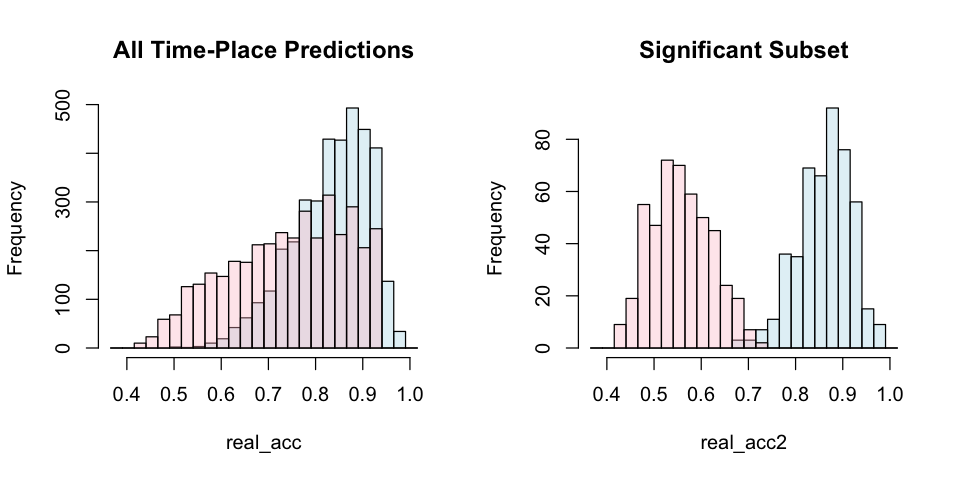

In [17]:
real_acc = results_tables[['real']][,'acc']
permat_acc = results_tables[['permat']][,'acc']
distsd = sd(c(real_acc, permat_acc))
distmean = mean(c(real_acc, permat_acc))
real_acc = (real_acc - distmean)
real_acc = (real_acc / distsd)
permat_acc = (permat_acc - distmean)
permat_acc = (permat_acc / distsd)
sig.diffs = which((real_acc-permat_acc) > 2)

real_acc2 = results_tables[['real']][sig.diffs,'acc']
permat_acc2 = results_tables[['permat']][sig.diffs,'acc']

real_acc = results_tables[['real']][,'acc']
permat_acc = results_tables[['permat']][,'acc']

options(repr.plot.width=8, repr.plot.height=4)
c1 <- rgb(173,216,230,max = 255, alpha = 90, names = "lt.blue")
c2 <- rgb(255,192,203, max = 255, alpha = 90, names = "lt.pink")

ax = seq(from=min(c(real_acc, permat_acc))-0.051, 
         to=max(c(real_acc, permat_acc))+0.051, by=0.025)
hgA_full <- hist(real_acc, breaks = ax, plot = FALSE) # Save first histogram data
hgB_full <- hist(permat_acc, breaks = ax, plot = FALSE) # Save 2nd histogram data

ax = seq(from=min(c(real_acc2, permat_acc2))-0.051, 
         to=max(c(real_acc2, permat_acc2))+0.051, by=0.025)
hgA_sig <- hist(real_acc2, breaks = ax, plot = FALSE) # Save first histogram data
hgB_sig <- hist(permat_acc2, breaks = ax, plot = FALSE) # Save 2nd histogram data

par(mfrow=c(1,2))
plot(hgA_full, col = c1, main='All Time-Place Predictions') # Plot 1st histogram using a transparent color
plot(hgB_full, col = c2, add = TRUE)     # Add 2nd histogram using different color

plot(hgA_sig, col = c1, main='Significant Subset') # Plot 1st histogram using a transparent color
plot(hgB_sig, col = c2, add = TRUE)     # Add 2nd histogram using different color


In [18]:
# add intra-cluster correlation, and cross-correlation with time and space 
old_cols = colnames(results_tables[['real']][sig.diffs, ])
sig_results = cbind(results_tables[['real']][sig.diffs, ], rep(NA, length(sig.diffs)),
                   rep(NA, length(sig.diffs)), rep(NA, length(sig.diffs)))
colnames(sig_results) <- c(old_cols, 'intra.cluster.corr', 'space.corr', 'time.corr')

for (sig_row in rownames(sig_results)){
    coef_row = sig_results[sig_row,colnames(ra_rar_df)]
    pos_coef = coef_row[coef_row > 0]
    subabund = ra_rar_df[,names(pos_coef)]
     subtimespace = orig_data[rownames(subabund),c('FallPeak', 'Latitude')]
    if (length(pos_coef) > 1){
        sig_results[sig_row, 'intra.cluster.corr'] = mean(as.dist(cor(subabund)))
        st_corr = apply(cor(x=subabund, y=subtimespace), 2, mean)
        sig_results[sig_row, 'space.corr'] = st_corr['Latitude']
        sig_results[sig_row, 'time.corr'] = st_corr['FallPeak']
    } else {
        print(c(sig_row, length(pos_coef)))
        flush.console()
    }
}


In [161]:
#options(repr.plot.width=8, repr.plot.height=3)
#par(mfrow=c(2,2))

# select significantly distinct time/places
tp_pairs = t(as.data.frame(strsplit(rownames(sig_results), "_")))
rownames(tp_pairs) <- rownames(sig_results)
top5Places = base::sort(table(tp_pairs[,1]), decreasing=T)[1:8]
sum(top5Places)/sum(table(tp_pairs[,1]))
places[names(top5Places), ]

top5Times = base::sort(table(tp_pairs[,2]), decreasing=T)[1:8]
sum(top5Times)/sum(table(tp_pairs[,2]))
times_[names(top5Times),]


[1] 0.3179916

,P.1,P.2,P.3,P.4,P.5,P.6,P.7
place.127,1,1,1,1,1,1,1
place.126,0,1,1,1,1,1,1
place.120,1,1,1,1,1,1,0
place.117,0,1,1,0,1,1,1
place.119,0,0,1,1,1,1,1
place.102,1,1,1,0,1,1,0
place.114,0,1,1,1,1,1,0
place.123,1,1,1,0,1,1,1


[1] 0.4979079

,T.1,T.2,T.3,T.4,T.5
time.25,0,0,1,1,1
time.26,1,1,1,1,0
time.21,1,0,0,1,1
time.30,0,1,1,1,1
time.20,1,0,1,0,1
time.18,1,1,0,0,1
time.19,1,0,1,1,0
time.24,0,1,0,1,1


[1] 400

,coef.pos.n,acc,ppv,npv,(Intercept),coef.mean.n,intra.cluster.corr,space.corr,time.corr,num.places,num.times,num.places.c,num.times.c
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
place.26_time.27,91,0.8745763,0.8039192,0.9265004,-2.1132078,0.04033477,0.03519101,-0.1476215,-0.03257729,2,4,#FF7F0E,#D62728
place.26_time.28,80,0.8779661,0.8284848,0.9136998,-0.6981330,0.02241775,0.04290172,-0.1357278,-0.01757481,2,4,#FF7F0E,#D62728
place.26_time.29,80,0.8433333,0.7930712,0.8850751,-0.8872793,0.02279268,0.04983153,-0.1716984,0.02156371,2,4,#FF7F0E,#D62728
place.26_time.30,80,0.8813559,0.8335137,0.9109806,-3.1764217,0.02717538,0.06488357,-0.1552849,0.12701469,2,4,#FF7F0E,#D62728
place.26_time.31,68,0.8366667,0.7964422,0.8833566,-0.3087634,0.01423918,0.04484662,-0.1699798,0.02199755,2,5,#FF7F0E,#9467BD
place.29_time.29,82,0.8933333,0.8934360,0.8947713,-0.4627523,0.03507609,0.07047887,0.2221640,0.06968744,3,4,#2CA02C,#D62728


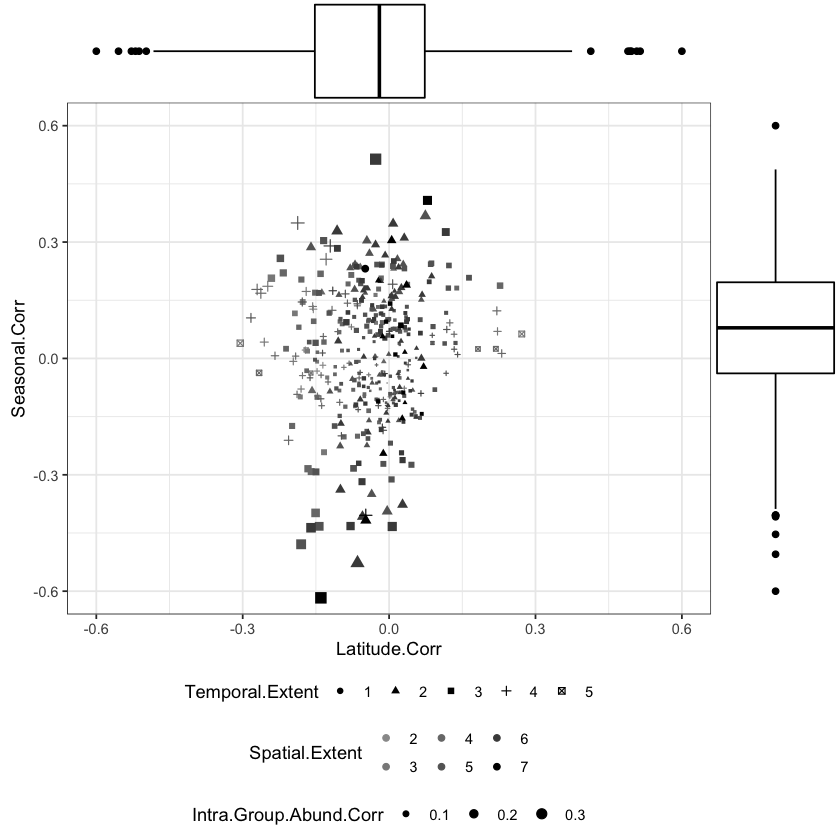

In [54]:
library(ggplot2)
library(ggExtra)

# select significantly distinct time/places
sig.tps = times_places[rownames(sig_results), 1:12]

# select perfect predictions including the first place
#best_rows1 = which((sig.tps[,1] == '1') & (sig_results[, 'acc'] == 1.))
best_rows1 = which((sig_results[, 'acc'] > 0.8))
length(best_rows1)
# get stats
stat.cols = c('coef.pos.n', 'acc', 'ppv', 'npv', '(Intercept)', 'coef.mean.n', 
              'intra.cluster.corr', 'space.corr', 'time.corr')
p1stats = as.data.frame(sig_results[best_rows1, stat.cols])

# add colors
p1stats = cbind.data.frame(p1stats, rowSums(apply(times_places[rownames(p1stats),1:7], 2, as.numeric)),
                           rowSums(apply(times_places[rownames(p1stats),8:12], 2, as.numeric)),
                           rep(NA, nrow(p1stats)), rep(NA, nrow(p1stats)))


color_cycle = c('#1F77B4', '#FF7F0E','#2CA02C', '#D62728', '#9467BD', '#8C564B',
               '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF')

colnames(p1stats) <- c(stat.cols, 'num.places', 'num.times', 'num.places.c', 'num.times.c')
for (dimcol in c('num.places', 'num.times')) {
    num_cats = length(unique(p1stats[,dimcol]))
    for (np in 1:num_cats){
        
        p1stats[which(p1stats[,dimcol] == as.character(np)), paste(dimcol, 'c', sep='.')] = color_cycle[np]
    }
}

# get places
p1defs = sig.tps[best_rows1,]

#p1coeffs = results_tables[['real']][p1, colnames(ra_rar_df)]

head(p1stats)
p1stats[is.na(p1stats[,'intra.cluster.corr']),'intra.cluster.corr'] <- min(p1stats[,'intra.cluster.corr'], na.rm=T)
p1stats[,'intra.cluster.corr'] <- p1stats[,'intra.cluster.corr'] + min(p1stats[,'intra.cluster.corr'])
p1stat_df = as.data.frame(p1stats)

#with(p1stat_df, symbols(x=space.corr, y=time.corr, circles=intra.cluster.corr, inches=0.1,
#                        ann=F, bg=num.places.c, fg=NULL, 
#                        main='Space:Time Correlations (colored by space coverage)'))

#with(p1stat_df, symbols(x=space.corr, y=time.corr, circles=intra.cluster.corr, inches=0.1,
#                        ann=F, bg=num.times.c, fg=NULL, 
#                        main='Space:Time Correlations (colored by time coverage)'))
options(repr.plot.width=7, repr.plot.height=7)
library(car)

p1stats[,'num.times'] <- factor(as.integer(p1stats[,'num.times']))
p1stats[,'num.places'] <- factor(as.integer(p1stats[,'num.places']))

colnames(p1stats)[colnames(p1stats) == 'space.corr'] = 'Latitude.Corr'
colnames(p1stats)[colnames(p1stats) == 'time.corr'] = 'Seasonal.Corr'
colnames(p1stats)[colnames(p1stats) == 'intra.cluster.corr'] = 'Intra.Group.Abund.Corr'
colnames(p1stats)[colnames(p1stats) == 'num.times'] = 'Temporal.Extent'
colnames(p1stats)[colnames(p1stats) == 'num.places'] = 'Spatial.Extent'

p1 <- ggplot(p1stats, aes(x=Latitude.Corr, y=Seasonal.Corr, 
                          color=Spatial.Extent, group=Temporal.Extent)) +
      geom_point(aes(size = Intra.Group.Abund.Corr, shape=Temporal.Extent)) + scale_size(range=c(0.0,2.9)) + 
      scale_colour_grey(start = 0.6, end = 0) + theme_bw() + coord_cartesian(xlim=c(-0.6, 0.6), ylim=c(-0.6, 0.6)) 

p1 <- p1 + theme(legend.position="bottom", legend.box="vertical", legend.margin=margin())

ggMarginal(p1, type="boxplot")


#bool2 = (p1stats[,'corr_score'] > 0.1)
#p1defs[bool2,]
#p1stats[bool2,]
#tail(p1stats[order(p1stats[,'(Intercept)']), ])
#tail(p1defs[order(p1stats[,'(Intercept)']), ])


In [102]:
cluster_file = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/oeu_clusters/cluster_assignments.txt'
cluster_vect = read.delim(cluster_file)
cluster_vect$asv.name <- rownames(cluster_vect)
cat(nrow(cluster_vect), " ", 'ASVs\n')
cluster_vect = cluster_vect[!is.na(cluster_vect$ward_clusters),]
cluster_df = data.frame(matrix(0, nrow=length(unique(cluster_vect$ward_clusters)), 
                               ncol=length(unique(cluster_vect$asv.name))))
colnames(cluster_df) <- unique(cluster_vect$asv.name)
rownames(cluster_df) <- unique(cluster_vect$ward_clusters)
for (r in rownames(cluster_df)){
    name_selector = which(cluster_vect$ward_clusters == r)
    cluster_df[r, cluster_vect[name_selector,'asv.name']] = 1
}

tp_coeffs = sig_results[,unique(cluster_vect$asv.name)]
tp_coeffs[tp_coeffs < 0 ] = 0
tp_coeffs[tp_coeffs > 0 ] = 1

oeu_memb_mat = as.matrix(cluster_df)
rownames(oeu_memb_mat) <- paste('OEU', rownames(oeu_memb_mat), sep=".")

tp_coeff_mat = as.matrix(tp_coeffs)
oeu_tpclust = t(cbind(t(oeu_memb_mat), t(tp_coeff_mat)))

tp_containment = matrix(0, nrow=nrow(tp_coeffs), ncol=nrow(oeu_memb_mat))
rownames(tp_containment)<- rownames(tp_coeffs)
colnames(tp_containment) <- rownames(oeu_memb_mat)

for (tp in rownames(tp_containment)){
    otus_in_tp = colnames(tp_coeff_mat)[which(tp_coeff_mat[tp,] > 0)]
    for (oeu in colnames(tp_containment)){
        otus_in_oeu = colnames(oeu_memb_mat)[which(oeu_memb_mat[oeu,] > 0)]
        tp_containment[tp, oeu] = length(which(otus_in_oeu %in% otus_in_tp)) / length(otus_in_oeu)
    }
}
tp_containment[ tp_containment < 0.66 ] = 0 
tp_containment_total = base::sort(rowSums(tp_containment), decreasing=T)

1432   ASVs


In [174]:

best.clusts = rownames(tail(head(p1stats[order(p1stats$Intra.Group.Abund.Corr, decreasing=T),], 50), 20))
times_places[best.clusts,8:12]

,T.1,T.2,T.3,T.4,T.5
place.98_time.25,0,0,1,1,1
place.97_time.30,0,1,1,1,1
place.117_time.6,1,1,0,0,0
place.117_time.25,0,0,1,1,1
place.127_time.15,0,0,0,1,1
place.120_time.15,0,0,0,1,1
place.124_time.16,1,1,1,0,0
place.63_time.30,0,1,1,1,1
place.97_time.16,1,1,1,0,0
place.119_time.16,1,1,1,0,0


In [167]:
stat_lat_min <- aggregate( orig_data[,'Latitude'], by=list(txm_data[,'StatName']), FUN=min)
stat_lat_max <- aggregate( orig_data[,'Latitude'], by=list(txm_data[,'StatName']), FUN=max)
stat_lat = cbind.data.frame(stat_lat_min, stat_lat_max[,2])
colnames(stat_lat) <- c("StationGroup", "Latitude.min", "Latitude.max")
stat_lat
seas_fp_min <- aggregate( orig_data[,'FallPeak'], by=list(orig_data[,'seasonality']), FUN=min)
seas_fp_max <- aggregate( orig_data[,'FallPeak'], by=list(orig_data[,'seasonality']), FUN=max)
seas_fp = cbind.data.frame(seas_fp_min, seas_fp_max[,2])
colnames(seas_fp) <- c("StationGroup", "Seasonal.min", "Seasonal.max")
seas_fp

StationGroup,Latitude.min,Latitude.max
<int>,<dbl>,<dbl>
1,39.24950,39.34873
2,38.64618,39.16369
3,38.41457,38.55505
4,38.13705,38.31870
5,37.68346,37.91011
6,37.41153,37.58847
7,36.99570,37.23653


StationGroup,Seasonal.min,Seasonal.max
<fct>,<dbl>,<dbl>
1,-0.9459381,-0.6500387
2,-0.2575024,0.1177867
3,0.3203978,0.4314604
4,0.7344523,0.7589990
5,0.9267713,0.9999517


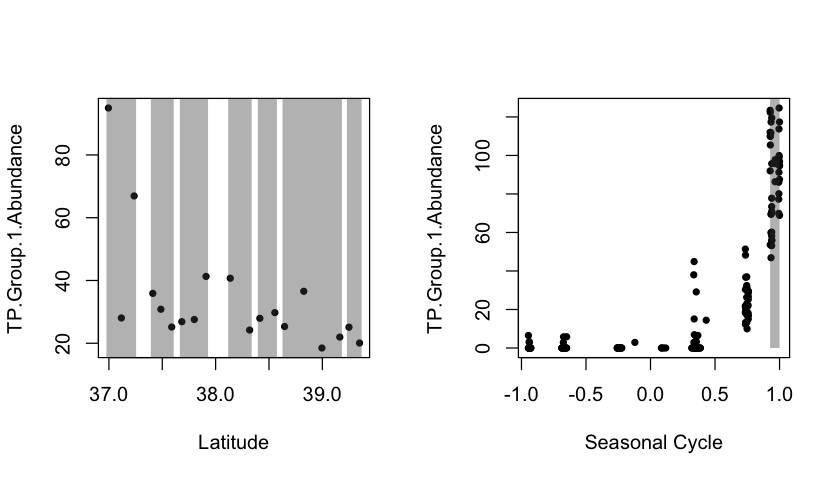

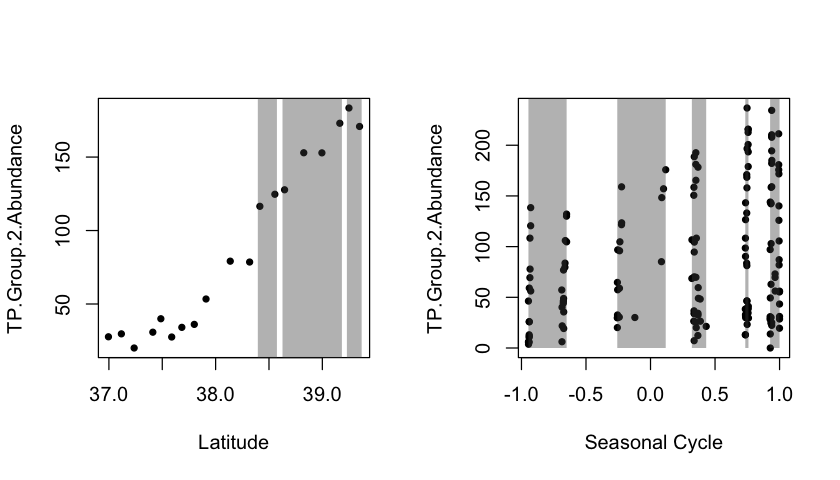

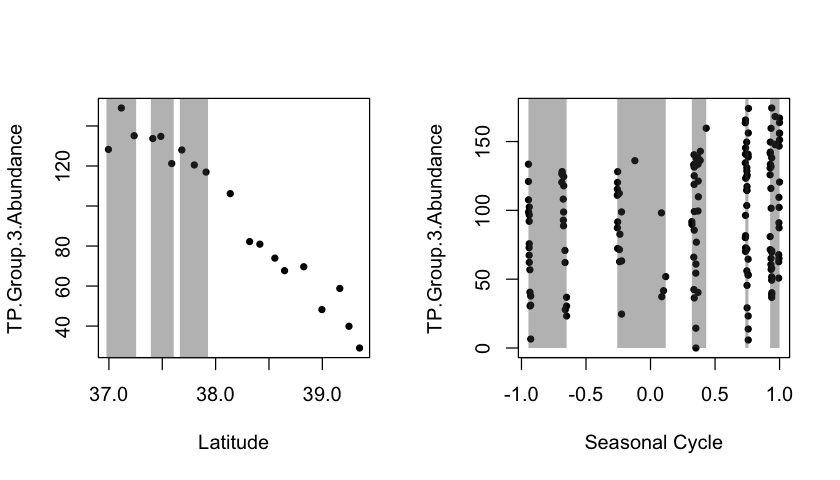

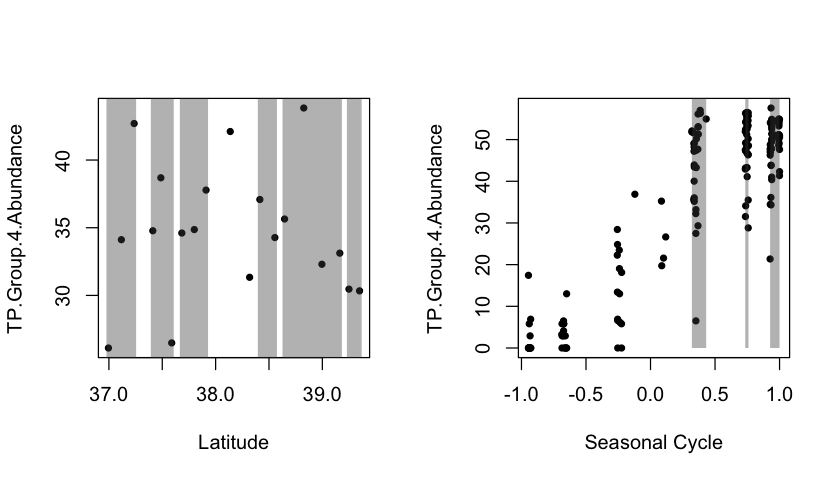

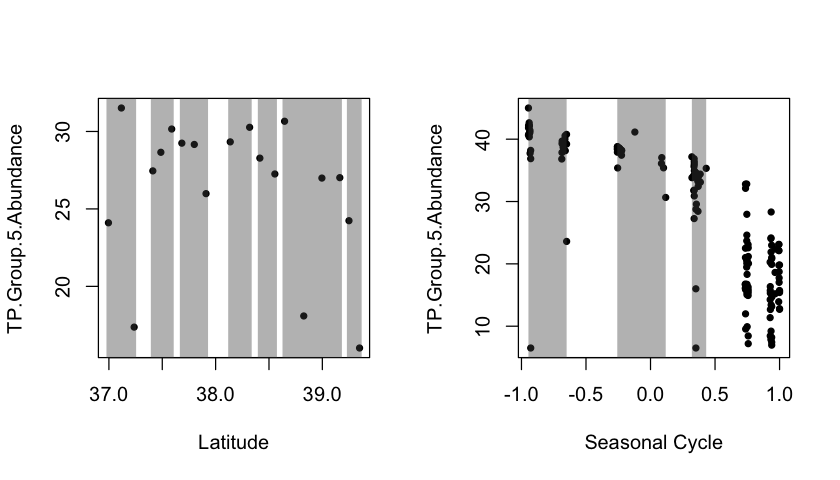

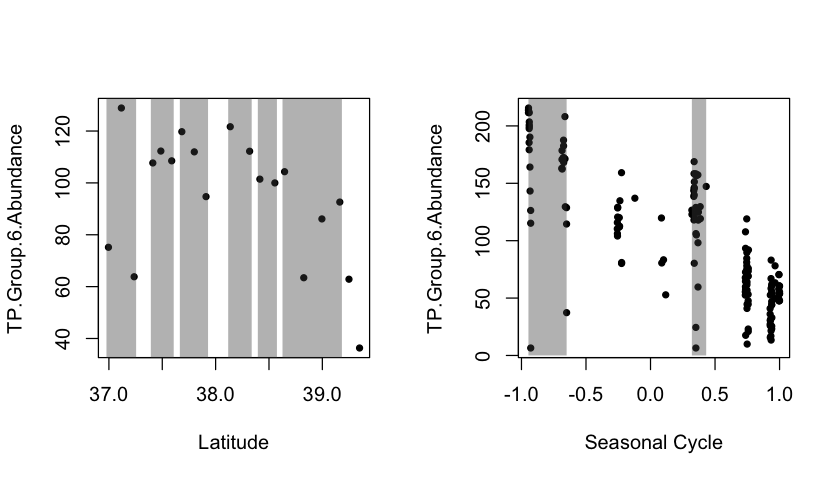

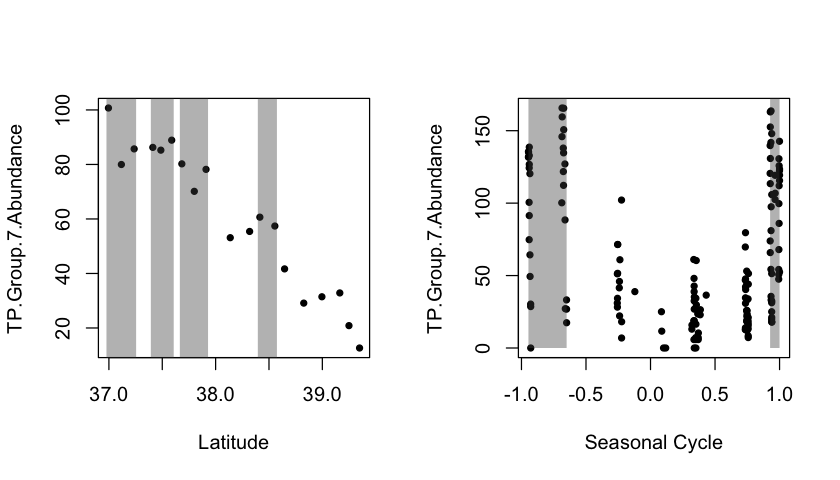

In [175]:
spacetime1 = which(p1stats[,'Temporal.Extent'] == 1)
spacetime2 = which(p1stats[,'Latitude.Corr'] == max(p1stats[,'Latitude.Corr']))
spacetime3 = which(p1stats[,'Latitude.Corr'] == min(p1stats[,'Latitude.Corr']))
spacetime4 = which(p1stats[,'Seasonal.Corr'] == max(p1stats[,'Seasonal.Corr']))
spacetime5 = which(p1stats[,'Seasonal.Corr'] == min(p1stats[,'Seasonal.Corr']))
spacetime6 = which(p1stats[,'Intra.Group.Abund.Corr'] == max(p1stats[,'Intra.Group.Abund.Corr']))

best_tps = rownames(p1stats)[unique(c(spacetime1, spacetime2, spacetime3, spacetime4, spacetime5, spacetime6))]
best_tps = c(best_tps, 'place.126_time.7', 'place.97_time.9')
p1stats2 = cbind.data.frame(p1stats, tp_containment_total[rownames(p1stats)])
colnames(p1stats2) <- c(colnames(p1stats), 'OEUs.contained')

sorted_samples = rownames(orig_data[with(orig_data, order(cruise_id, Station)),])

for (tp_idx in 1:length(best_tps)){
    this_tp = best_tps[tp_idx]
    best_set = sig_results[this_tp, colnames(ra_rar_df)]
    otus_in_bs = colnames(ra_rar_df)[which(best_set > 0)]
    abunds_bs = rowSums(predictor_sets[['real']][sorted_samples, otus_in_bs])
    aggabunds = cbind(abunds_bs, orig_data[sorted_samples, 'Latitude'])
    colnames(aggabunds) <- c(this_tp, 'Latitude')
    aggspace <- aggregate(aggabunds, by=list(aggabunds[,'Latitude']), FUN=mean)
    aggabunds = cbind(abunds_bs, orig_data[sorted_samples, 'FallPeak'])
    colnames(aggabunds) <- c(this_tp, 'Seasonality')
    aggtime <- aggregate(aggabunds, by=list(aggabunds[,'Seasonality']), FUN=mean)

    options(repr.plot.width=7, repr.plot.height=4)
    par(mfrow=c(1,2))
    plot(aggspace[, 'Latitude'], aggspace[, this_tp], pch=20, xlab='Latitude', 
         ylab=paste("TP.Group", tp_idx, 'Abundance',  sep="."))
    sublat = stat_lat[which(stat_lat[,1] %in% which(sig.tps[this_tp,1:7] == '1')),]
    for (r in 1:nrow(sublat)){
        latbox = c(sublat[r,c(2)]*0.9995, sublat[r,c(3)]*1.0005, sublat[r,c(3)]*1.0005, sublat[r,c(2)]*0.9995)
        abundbox1 = c(0, 0, max(aggspace[, this_tp])*1.2, max(aggspace[, this_tp])*1.2)
        polygon(x=latbox, y=abundbox1, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }

    plot(aggtime[, 'Seasonality'], aggtime[, this_tp], pch=20, xlab='Seasonal Cycle', 
         ylab=paste("TP.Group", tp_idx, 'Abundance',  sep="."))
    subseas = seas_fp[which(seas_fp[,1] %in% which(sig.tps[this_tp,8:12] == '1')),]
    for (r in 1:nrow(subseas)){
        seasbox = c(subseas[r,c(2)], subseas[r,c(3)], subseas[r,c(3)], subseas[r,c(2)])
        abundbox2 = c(0, 0, max(aggtime[, this_tp])*1.2, max(aggtime[, this_tp])*1.2)
        polygon(x=seasbox, y=abundbox2, col=rgb(.3,.3,.3,max=1,alpha=0.4), border=NA)
    }
}

Create all possible times and places

In [ ]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(foreach))

suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(grid))

In [ ]:


env_data$Year <- factor(env_data$Year)
env_data$Month <- factor(env_data$Month)
env_data$habitat <- factor(env_data$habitat)

transect_data_f = "/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data/transect_mdata_colset_1.tsv"
tran_df <- read.delim(transect_data_f, row.names=1)
missing_columns = setdiff(colnames(tran_df), colnames(env_data))

for (i in missing_columns){
    env_data[,i] <- NA
    env_data[rownames(tran_df),i] = tran_df[rownames(tran_df), i]
}

print(colnames(env_data))

In [ ]:
env_data[,'StatName'] <- NA
env_data[which(env_data[,'StationName'] %in% c('CB22', 'CB31', 'CB32')),'StatName'] <- '1'
env_data[which(env_data[,'StationName'] %in% c('CB33C', 'CB41C')),'StatName'] <- '2'
env_data[which(env_data[,'StationName'] %in% c('CB42C', 'CB43C', 'CB44', 'CB51')),'StatName'] <- '3'
env_data[which(env_data[,'StationName'] %in% c('CB52', 'CB53', 'CB54', 'CB71')),'StatName'] <- '4'
env_data[which(env_data[,'StationName'] %in% c('CB61', 'CB62', 'CB63', 'CB64')),'StatName'] <- '5'
env_data[which(env_data[,'StationName'] %in% c('CB72', 'CB73', 'CB74')),'StatName'] <- '6'
env_data$StatName <- factor(env_data$StatName)
print(sum(is.na(env_data[,'StatName'])))
table(env_data$StatName)

our_station = env_data[,'StationName'] == 'CB33C' 
env_data[,'depth_segment'] <- NA
env_data[which((!our_station) & env_data$depth_float > 2), 'depth_segment'] = 'Bottom'
env_data[which(env_data$depth_float < 2), 'depth_segment'] = 'Top'
env_data[which(our_station & env_data$depth_float > 11), 'depth_segment'] = 'Bottom'
env_data[is.na(env_data[,'depth_segment']),'depth_segment'] = 'Mid'
env_data[,'depth_segment'] = factor(env_data[,'depth_segment'], levels=c('Top', 'Mid', 'Bottom'))
table(env_data$depth_segment)


env_data[,'Sal.Zone'] <- NA
oligohaline <- c('CB22', 'CB31')
mesohaline <- c('CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54')
polyhaline <- c('CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74')
env_data[which(env_data[,'StationName'] %in% oligohaline),'Sal.Zone'] <- 'oligo'
env_data[which(env_data[,'StationName'] %in% mesohaline),'Sal.Zone'] <- 'meso'
env_data[which(env_data[,'StationName'] %in% polyhaline),'Sal.Zone'] <- 'poly'
env_data$Sal.Zone <- factor(env_data$Sal.Zone, levels=c('oligo', 'meso', 'poly'))
print(sum(is.na(env_data[,'Sal.Zone'])))
table(env_data$Sal.Zone)

In [ ]:
tenv_data = env_data[!(is.na(env_data$TON)),]
colnames(tenv_data)

In [ ]:
tenv_data$Years <- NA
tenv_data$Years <- (tenv_data$julian_day - 365)/365
tenv_data$Season <- tenv_data$anti_day_length

In [ ]:
# Select variables and clean up response set

select_env = c('Years', 'SALINITY', 'Season', 'SIGMA_T', 'StatName', 'habitat', 
               'NO3F', 'NO2F', 'CHLA', 'TP', 'PHEO', 'NH4F', 'WTEMP', 
               'Discharge_Susquehanna_14', 'DO')

response_set = tenv_data[,select_env]
colnames(response_set)[colnames(response_set) == 'habitat'] = 'Habitat'
colnames(response_set)[colnames(response_set) == 'SALINITY'] = 'Salinity'
colnames(response_set)[colnames(response_set) == 'NO3F'] = 'NO3'
colnames(response_set)[colnames(response_set) == 'NO2F'] = 'NO2'
colnames(response_set)[colnames(response_set) == 'NH4F'] = 'NH4'
colnames(response_set)[colnames(response_set) == 'Discharge_Susquehanna_14'] = 'Discharge'
colnames(response_set)[colnames(response_set) == 'StatName'] = 'Station.Group'
colnames(response_set)[colnames(response_set) == 'SIGMA_T'] = 'Density'

ind <- sapply(response_set, is.numeric)
for (isnum in names(ind)[ind]){
    response_set[,isnum] <- as.numeric(scale(response_set[,isnum]))
    cat(isnum, " ", mean(response_set[,isnum] ), " -- ", sd(response_set[,isnum]), '\n')
}

In [ ]:
# Load data and fix OEUs
fxn_file = "/Users/login/Google Drive/SiYi_Xiaotong_Materials/FAPROTAX_counts_silva.txt"
taxa_file = '/Users/login/Google Drive/SiYi_Xiaotong_Materials/taxa_family_counts_relabund.txt'
otu_table_file = "/Volumes/KeithSSD/CB_V4/otu_data/final_rarefied_table.tsv"

data_files = list('Taxa.Family'=taxa_file, 'Fxn.SILVA'=fxn_file, 'ASV.OEU'=otu_table_file)
data_objects = list()
for (i in names(data_files))
    data_objects[[i]] = read.delim(data_files[[i]], row.names=1)[rownames(response_set),]

# relabund 
data_objects$ASV.OEU = ((data_objects$ASV.OEU + 0.1)/rowSums(data_objects$ASV.OEU + 0.1))*1e6

# remove unclassifieds
data_objects$Taxa.Family$nan <- NULL

# remove garbage functions (>.95 correlation with other similarly names functions and possibly also irrelevant)
to_drop = c('methylotrophy', 'aerobic_ammonia_oxidation', 'sulfate_respiration',
            'dark_sulfite_oxidation', 'arsenate_respiration', 'nitrite_ammonification',
            'dissimilatory_arsenate_reduction', 'nitrite_denitrification', 
            'nitrous_oxide_denitrification', 'nitrate_denitrification', 'fumarate_respiration',
            'mammal_gut', 'plant_pathogen',  'cyanobacteria', 'phototrophy', 
            'anoxygenic_photoautotrophy_S_oxidizing', 'anoxygenic_photoautotrophy_Fe_oxidizing',
            'nitrate_respiration', 'aliphatic_non_methane_hydrocarbon_degradation', 
            'aerobic_chemoheterotrophy', 'nitrite_respiration', 'dark_sulfide_oxidation')

to_drop = unique(c(to_drop, colnames(data_objects$Fxn.SILVA)[colSums(data_objects$Fxn.SILVA) == 0]))
data_objects$Fxn.SILVA[,to_drop] <- NULL

drop_tax = colnames(data_objects$Taxa.Family)[colSums(data_objects$Taxa.Family) == 0]
data_objects$Taxa.Family[,drop_tax] <- NULL

cluster_file = '/Volumes/KeithSSD/CB_V4/otu_data/otu_cluster_vector.txt'
cluster_vect = read.delim(cluster_file)
cluster_vect$asv.name <- rownames(cluster_vect)
cat(nrow(cluster_vect), " ", 'OTUs\n')
cluster_vect = cluster_vect[!is.na(cluster_vect$cluster_number),]
oeu_df = data.frame(matrix(NA, nrow=dim(response_set)[1], ncol=max(cluster_vect$cluster_number)))
rownames(oeu_df) <- rownames(response_set)
colnames(oeu_df) <- unique(cluster_vect$cluster_number)
cluster_summary = data.frame('n'=c(), 'correl'=c(), 'total'=c())
for (clust in colnames(oeu_df)){
    cl_mems = cluster_vect[which(cluster_vect$cluster_number == clust), 'asv.name']
    average_cor = mean(as.dist(cor(data_objects$ASV.OEU[, cl_mems], method="pearson")))
    while ((average_cor < 0.75) & (length(cl_mems) > 1)) {
        mini_cors = data.frame('cor_i' = c())
        for (cl_mem in cl_mems){
            other_mems = setdiff(cl_mems, c(cl_mem))
            mini_cors[cl_mem, 'cor_i'] = mean(cor(x=data_objects$ASV.OEU[, cl_mem], y=data_objects$ASV.OEU[, other_mems], 
                                       method="pearson"))
        }
        loser = rownames(mini_cors)[which(mini_cors$cor_i == min(mini_cors$cor_i))]
        cl_mems = cl_mems[!(cl_mems %in% loser)]
        if (length(cl_mems) > 1){
            average_cor = mean(as.dist(cor(data_objects$ASV.OEU[, cl_mems], 
                                           data_objects$ASV.OEU[, cl_mems], 
                                           method="pearson")))
        }
    }
    
    if ((length(cl_mems) > 1) & (average_cor >= 0.75)) {
        cluster_summary[clust, 'n'] = length(cl_mems)
        cluster_summary[clust, 'correl'] = mean(as.dist(cor(data_objects$ASV.OEU[, cl_mems], method="pearson")))
        oeu_df[,clust] = rowSums(data_objects$ASV.OEU[, cl_mems])
        cluster_summary[clust, 'mean.abund'] = mean(log(oeu_df[,clust] + 1))
        }
}
oeu_df = oeu_df[,which(colSums(is.na(oeu_df)) == 0)]
cat(sum(cluster_summary$n), " ", 'clustered\n')
cat(length(cluster_summary$n), " ", 'clusters\n')
colnames(oeu_df) <- paste("OEU", colnames(oeu_df), sep='.')
data_objects[['ASV.OEU']] <- log(oeu_df + 1)
data_objects[['Fxn.SILVA']] <- log(data_objects$Fxn.SILVA + 1)
data_objects[['Taxa.Family']] <- log(data_objects$Taxa.Family + 1)

In [ ]:
dim(oeu_df)
sum(cluster_summary$n)/1561
y = table(cluster_summary$n)
sum(y[names(y)[1:4]]) / sum(y)
mean(cluster_summary$correl)
y

In [ ]:
rsq <- function (x, y) cor(x, y) ^ 2

In [ ]:
numCores <- 3
counter = 0
folds = 10

score_summaries = expand.grid(names(data_objects), c('Full', 'Slim'))
score_summaries = paste(score_summaries$Var1, score_summaries$Var2, sep=".")
predictor_list = unlist(lapply(data_objects, colnames))
names(predictor_list) <-NULL
all_summaries = c(score_summaries, predictor_list)
vs_trial_df = data.frame(matrix(nrow=dim(response_set)[2], ncol=length(all_summaries)))
rownames(vs_trial_df) = colnames(response_set)
colnames(vs_trial_df) = all_summaries

In [ ]:
# start the timer
start_time = Sys.time()
# iterate over predictor sets
for (trial in names(data_objects)){
    # extract predictor matrix
    raw_pred_df = data_objects[[trial]]
    pred_cols = colnames(raw_pred_df)
    print(c("Trial", trial))
    
    for (resp in names(response_set)){
        # set seed 
        counter = counter + 1
        set.seed(123*counter)
        # combine into 1 object

        pred_resp = cbind.data.frame(raw_pred_df, response_set[,resp])
        colnames(pred_resp) <- c(colnames(raw_pred_df), resp)
        
        # make a tune grid
        if (class(response_set[,resp]) == 'factor'){
            default.var = floor(sqrt(ncol(raw_pred_df)))
        } else {
            default.var = max(floor(ncol(raw_pred_df)/3), 1)
        }
        
        # tune the RF model (1)
        control <- trainControl(method="cv", number=5)
        tune.grid.full <- expand.grid(mtry=unique(round(default.var*(seq(0.5, 1.5, 0.1)))))
        rf_default <- train(x=pred_resp[,pred_cols], y=pred_resp[,resp], 
                            method="rf", tuneGrid=tune.grid.full, trControl=control)
        opt_mtry_full = rf_default$bestTune[['mtry']]

        # prefilter
        prf_model = randomForest(x=pred_resp[,pred_cols], y=pred_resp[,resp], 
                                 ntree = 250, random_state=counter, mtry=opt_mtry_full,
                                 importance=T)

        # get full importances and prefilter
        pvar_import = importance(prf_model, type=1, scale=F)
        sorted_VIs = base::sort(pvar_import, index.return=T)
        sel_vars = rownames(pvar_import)[sorted_VIs$ix[1:40]]

        # retune 3
        if (class(response_set[,resp]) == 'factor'){
            default.var.slim = floor(sqrt(length(sel_vars)))
        } else {
            default.var.slim = max(floor(length(sel_vars)/3), 1)
        }
        
        tune.grid.slim <- expand.grid(mtry=unique(round(default.var.slim*(seq(0.5, 1.5, 0.1)))))
        rf_slim <- train(x=pred_resp[,sel_vars], y=pred_resp[,resp], 
                         method="rf", tuneGrid=tune.grid.slim, trControl=control)
        opt_mtry_slim = rf_slim$bestTune[['mtry']]

        cat(trial, "--", resp, "\n")
        end_time = Sys.time(); print(end_time - start_time);
        
        # fit full and slim models 10fold
        registerDoParallel(numCores)
        results = foreach(i=1:folds, .combine=data.frame) %dopar% {

            # split into test/train
            this_counter = counter + i
            set.seed(123*this_counter)
            train_ind = createDataPartition(response_set[,resp], p=.75, list = FALSE)
            train_df <- pred_resp[train_ind, ]
            test_df <- pred_resp[-train_ind, ]
            
            # if factors were dropped from training or test df, drop from both 
            if (class(response_set[,resp]) == 'factor') {
                avail_levels = intersect(unique(test_df[,resp]), unique(test_df[,resp]))
                missing_levels = setdiff(unique(pred_resp[,resp]), avail_levels)
                if (length(missing_levels) > 0){
                    train_df = train_df[!(train_df[,resp] %in% missing_levels),]
                    test_df = test_df[!(test_df[,resp] %in% missing_levels),]
                    test_df[,resp] <- droplevels(test_df[,resp])
                    train_df[,resp] <- droplevels(train_df[,resp])
                }
            }

            rf_model = randomForest(x = train_df[,sel_vars], y = train_df[,resp], 
                                    ntree = 250, random_state=this_counter, mtry=opt_mtry_slim)
            
            rf_model2 = randomForest(x = train_df[,pred_cols], y = train_df[,resp], 
                                     ntree = 250, random_state=this_counter, mtry=opt_mtry_full,
                                    importance=T)

            # preditct for both
            rf_pred_test = predict(rf_model, newdata = test_df[,sel_vars])
            rf_pred_test2 = predict(rf_model2, newdata = test_df[,pred_cols])

            # score 
            if (class(response_set[,resp]) == 'factor') {
                rf_cm = confusionMatrix(rf_pred_test, test_df[,resp])
                rf_score = 1 - rf_cm$overall['Accuracy']

                rf_cm2 = confusionMatrix(rf_pred_test2, test_df[,resp])
                rf_score2 = 1 - rf_cm2$overall['Accuracy']
            } else {
                rf_score = postResample(pred = rf_pred_test, obs = test_df[,resp])[['MAE']]
                rf_score2 = postResample(pred = rf_pred_test2, obs = test_df[,resp])[['MAE']]
            }    

            # report
            var_import = as.data.frame(importance(rf_model2, type=1, scale=T))
            colnames(var_import) <- paste('MetricOrDeltaMetric', i, sep=".")
            var_import[paste(trial, 'Full', sep="."), c(1)] = rf_score2
            var_import[paste(trial, 'Slim', sep="."), c(1)] = rf_score
            var_import
        }
        
        stopImplicitCluster()
        flush.console()

        # move counter forward to initiate new seeds 
        counter = counter + folds

        # take the mean of each fold 
        scores = apply(results, MARGIN=1, FUN=mean)
        for (score_col in names(scores))
            vs_trial_df[resp, score_col] = scores[[score_col]]

        print(paste('Complete: ', round((counter/(dim(response_set)[2]*3*11))*100, 1), "%", sep="" ))
        end_time = Sys.time(); print(end_time - start_time);

    }
}

write.table(x = vs_trial_df,
            file = "/Volumes/KeithSSD/CB_V4/otu_data/beta_diversity_analysis/beta_diversity_varsel_final3.txt", 
            row.names = T, 
            col.names = T, 
            sep = '\t')


In [ ]:
options(repr.plot.width=7.5, repr.plot.height=5)
to_plot1 = t(vs_trial_df[,1:6])
to_plot2 = apply(as.data.frame(to_plot1), 2, as.numeric)
to_plot2 = cbind.data.frame(to_plot2, factor(c(rep('Full', 3), rep('Reduced', 3))), 
                 factor(rep(names(data_objects), 2)))
colnames(to_plot2) <- c(colnames(to_plot1), 'Model.Size', 'Data.Type')
to_plot3 = melt(to_plot2, id.vars=c("Data.Type", 'Model.Size'), 
                measure.vars=colnames(to_plot1), variable.name='Variable',
                value.name='Error')
to_plot4 = to_plot3[which(to_plot3$Model.Size != 'Reduced'),]
#to_plot4 = to_plot4[which(to_plot4$Variable != 'Pct.Tot.Depth'),]
#to_plot4$Variable <- droplevels(to_plot4$Variable)
#levels(to_plot4$Variable)
to_plot4$Data.Type <- factor(to_plot4$Data.Type, levels=c('ASV.OEU', 'Taxa.Family', 'Fxn.SILVA'))
levels(to_plot4$Data.Type) <- c('OEU', 'Fxn', 'Taxa')

to_plot4$Variable <-  factor(to_plot4$Variable, levels=c('Years', 'Season', 'Discharge', 'WTEMP', 
                                                         'Salinity', 'Station.Group', 'Density', 
                                                         'Habitat', 'NO3', 'NO2', 'NH4', 'CHLA', 
                                                         'PHEO', 'TP'))

bp <- ggplot(to_plot4, aes(x=Data.Type, y=Error, fill=Data.Type)) + 
      geom_bar(stat="identity", position=position_dodge()) + 
      facet_wrap(~ Variable, ncol=5) + scale_fill_grey() + 
      theme_minimal() + theme(text = element_text(size=12), axis.text.x=element_blank())
bp


In [ ]:
res.aov <- aov(Error ~ Data.Type, data = to_plot4)
summary(res.aov)
TukeyHSD(res.aov)
aggregate(to_plot4[,'Error'], by=list(to_plot4[,'Data.Type']), mean)
var_perf = aggregate(to_plot4[,'Error'], by=list(to_plot4[,'Variable']), min)
var_perf[,'best'] <- NA
for (v in 1:nrow(var_perf)){
    vsub = to_plot4[which(to_plot4$Variable == var_perf[v, 'Group.1']),]
    vstr = paste(vsub[(which(vsub$Error == min(vsub$Error))), 'Data.Type'], collapse=", ")
    var_perf[v ,'best'] <- vstr
}
var_perf

In [ ]:
options(repr.plot.width=7.5, repr.plot.height=5)
trial_df = vs_trial_df
fxnNames = colnames(data_objects[['Fxn.SILVA']])
familyNames = colnames(data_objects[['Taxa.Family']])
oeuNames = colnames(data_objects[['ASV.OEU']])
Max.VI.Taxa = apply(trial_df[,familyNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Max.VI.Fxns = apply(trial_df[,fxnNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Max.VI.OEU = apply(trial_df[,oeuNames], MARGIN=1, FUN=function(x) {max(x, na.rm=T)})
Mean.VI.Taxa = apply(trial_df[,familyNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})
Mean.VI.Fxns = apply(trial_df[,fxnNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})
Mean.VI.OEU = apply(trial_df[,oeuNames], MARGIN=1, FUN=function(x) {mean(x, na.rm=T)})

dropped_df = cbind.data.frame(Max.VI.Taxa, Max.VI.Fxns, Max.VI.OEU,
                              Mean.VI.Taxa, Mean.VI.Fxns, Mean.VI.OEU)
dropped_df$Variables <- rownames(dropped_df)
to_plot5 = to_plot4
colnames(to_plot5) <- c('Data.Type', 'Stat', 'Variable', 'Var.Importance')
data.types_ = c('Taxa', 'Fxn', 'OEU')
to_plot6 = to_plot5
to_plot5[,'Stat'] = 'Max'
to_plot6[,'Stat'] = 'Mean'
for (r in rownames(dropped_df)){
    for (c in 1:3){
        b1 = to_plot5$Data.Type == data.types_[c]
        b2 = to_plot5$Variable == r
        to_plot5[which(b1 & b2), 'Var.Importance'] = dropped_df[r, c]
        to_plot5[which(b1 & b2), 'Stat'] = 'Max'
        to_plot6[which(b1 & b2), 'Var.Importance'] = dropped_df[r, c+3]
        to_plot6[which(b1 & b2), 'Stat'] = 'Mean'
    }
}
to_plot7 = rbind.data.frame(to_plot5, to_plot6)

bp <- ggplot(to_plot5, aes(x=Data.Type, y=Var.Importance, fill=Data.Type)) + 
      geom_bar(stat="identity", position=position_dodge()) + 
      facet_wrap(~ Variable, ncol=5) + scale_fill_grey() + 
      theme_minimal() + theme(text = element_text(size=12), axis.text.x=element_blank())
bp



In [ ]:
# CHLA NO2, WTEMP, Fxn fxnNames
# Discharge Taxa familyNames
# PHEO and NO3 OEU oeuNames
response_set2 = response_set

varimport_df = trial_df[,c(familyNames, fxnNames, oeuNames)]
good_wc_columns = c('CHLA', 'PHEO', 'NO3', 'NO2', "Discharge", "WTEMP", 'NH4', 'Season')

# extract correlations between environmental data and 16S-based predictors
feat_corrs = data.frame(matrix(nrow=ncol(varimport_df), ncol=length(good_wc_columns)))
colnames(feat_corrs) <- good_wc_columns
rownames(feat_corrs) <- colnames(varimport_df)

all_features = cbind.data.frame(data_objects[['Taxa.Family']], 
                                data_objects[['Fxn.SILVA']], 
                                data_objects[['ASV.OEU']])
for (feat in rownames(feat_corrs)){
    for (a_var in colnames(feat_corrs)){
        env_pred = cbind.data.frame(response_set2[,a_var], all_features[,feat])
        feat_corrs[feat, a_var] = cor(env_pred)[1,2]
    }
}

corr_signs = feat_corrs
corr_signs = ifelse(corr_signs < 0, -1, 1)
sum(colSums(feat_corrs == 0))



In [ ]:
vidf_num_rows=length(data_objects)*length(good_wc_columns)*3

var.import.df = data.frame(matrix(nrow=vidf_num_rows, ncol=5))
counter = 0
colnames(var.import.df) <- c('Data.Type', 'Variable', 'Name', 'Importance', 'Correlation')
colsets = list('Taxa'=familyNames, 'Fxn'=fxnNames, 'OEU'=oeuNames)
for (a_var in good_wc_columns){
    for (data.tipo in names(colsets)){
        all_feats = trial_df[a_var, colsets[[data.tipo]]]
        all_feats = all_feats[,which(!is.na(all_feats[a_var,]))]
        srt_feats = base::sort(all_feats, decreasing = T)[,1:3]
        for (rank in 1:3){
            counter = counter + 1
            var.import.df[counter, 'Data.Type'] = data.tipo
            var.import.df[counter, 'Variable'] = a_var
            var.import.df[counter, 'Name'] = names(srt_feats)[rank]
            var.import.df[counter, 'Importance'] = srt_feats[rank]
            var.import.df[counter, 'Correlation'] = feat_corrs[names(srt_feats)[rank], a_var]
        }
    }
}

var.import.df[1:25, ]
var.import.df[25:50, ]
var.import.df[50:72, ]
table(var.import.df$Name)

In [ ]:

tenv_data$Cruise.Num <- NA
varJD = tenv_data$julian_day
tenv_data[ (varJD < 572), 'Cruise.Num'] <- '1'
tenv_data[ (varJD > 571) & (varJD < 601), 'Cruise.Num'] <- '2'
tenv_data[ (varJD > 600) & (varJD < 621), 'Cruise.Num'] <- '3'
tenv_data[ (varJD > 841) & (varJD < 870), 'Cruise.Num'] <- '4'
tenv_data[ (varJD > 869) & (varJD < 899), 'Cruise.Num'] <- '5'
tenv_data[ (varJD > 898) & (varJD < 919), 'Cruise.Num'] <- '6'
tenv_data[ (varJD > 918) & (varJD < 962), 'Cruise.Num'] <- '6'
tenv_data[ (varJD > 961) & (varJD < 984), 'Cruise.Num'] <- '7'
tenv_data[ (varJD > 983) & (varJD < 1006), 'Cruise.Num'] <- '8'
tenv_data[ (varJD > 1005), 'Cruise.Num'] <- '9'
table(tenv_data$Cruise.Num)

resp_set2 = response_set
resp_set2$Cruise.Num = factor(tenv_data$Cruise.Num)



In [ ]:
options(repr.plot.width=7, repr.plot.height=5)

cruise.stat = paste("C", resp_set2$Cruise.Num, 
                    "S", as.character(resp_set2$Station.Group), sep=".")
length(unique(cruise.stat))
cruise.stat.levels = expand.grid(paste("S", 1:6, sep="."), paste("C",1:9, sep="."))
cruise.stat.levels = paste(cruise.stat.levels$Var2, cruise.stat.levels$Var1, sep=".")

resp_set2[,'Cruise.Station'] <- droplevels(factor(cruise.stat, levels=cruise.stat.levels))
srt_response = resp_set2[with(resp_set2, order(Cruise.Station)),]
colorder = rownames(srt_response)
oeu_df2 = data_objects[['ASV.OEU']]

oeu_df3 = cbind.data.frame(oeu_df2[colorder,], resp_set2[,'Cruise.Station'])
colnames(oeu_df3) <- c(colnames(oeu_df2), 'Cruise.Station')
oeu_df3[,'id'] <- rownames(oeu_df3)
oeu_melt = melt(oeu_df3, id.vars=c("id", 'Cruise.Station'), 
                measure.vars=colnames(oeu_df2), variable.name='OEU',
                value.name='Abund')

oeu_melt_agg = aggregate(Abund~Cruise.Station+OEU, oeu_melt, FUN=mean)
oeu_df4 = dcast(oeu_melt_agg, Cruise.Station ~ OEU, value.var='Abund')


rownames(oeu_df4) <- oeu_df4$Cruise.Station
oeu_df4$Cruise.Station <- NULL
oeu_vars = apply(oeu_df4, 2, var)
sorted_oeu_vars = base::sort(oeu_vars, index.return=T, decreasing=T)
hi_var_oeus = names(oeu_vars)[sorted_oeu_vars$ix[1:100]]
oeu_df5 = oeu_df4[,hi_var_oeus]
srt_oeu = as.matrix(t(oeu_df5))

hmanno = data.frame('Season'=c(), 'Latitude'=c())

for (n in colnames(srt_oeu)){
    samps.lats = tenv_data[which(resp_set2$Cruise.Station == n), 'Latitude']
    hmanno[n, 'Latitude'] = mean(samps.lats)
    stat.seasonx = tenv_data[which(resp_set2$Cruise.Station == n), 'anti_day_length']
    hmanno[n, 'Season'] = mean(stat.seasonx)
    stat.month = (as.numeric(tenv_data[which(resp_set2$Cruise.Station == n), 'julian_day'])-365)/365
    hmanno[n, 'Years'] = mean(stat.month)
}

row_ha = HeatmapAnnotation(
    'Years' = hmanno$Years,
    'Season' = hmanno$Season, 
    'Latitude' = hmanno$Latitude, 
    col = list('Years' = colorRamp2(c(min(hmanno$Years),max(hmanno$Years)), c("#FEBAB9", "#A90301")),
               'Season' = colorRamp2(c(-.93,0.99), c('#F4D6FC', '#780197')),
               'Latitude' = colorRamp2(as.vector(quantile(hmanno$Latitude, c(0.05, 0.95))),
                                       c("#A7FDA7", "#018501")))
)


col_fun = colorRamp2(as.vector(quantile(srt_oeu, c(0.1, 0.5, 0.9))), c("#FFFFFF", '#888888', "#000000"))

Heatmap(srt_oeu, col = col_fun, name='LogRPM', top_annotation = row_ha, 
        cluster_columns=F,  show_row_names = F, show_column_names=F,
        column_title_side='bottom', column_title='Samples', row_title='OEUs',
        row_title_side='left', gap = unit(1, "mm"))
?Heatmap
#colSide <- brewer.pal(9, "Set1")[my_group]
#colMain <- colorRampPalette(brewer.pal(8, "Blues"))(25)
#heatmap(data, Colv = NA, Rowv = NA, scale="column" , RowSideColors=colSide, col=colMain   )

In [ ]:
options(repr.plot.width=7, repr.plot.height=8)
Heatmap(srt_oeu, col = col_fun, name='LogAbund', top_annotation = row_ha, 
        cluster_columns=F,  show_row_names = T, show_column_names=F, row_names_gp = gpar(fontsize = 7))

In [ ]:
taxa_file2 = "/Volumes/KeithSSD/CB_V4/otu_data/dada2_outputs/taxa_table_with_OTUs.txt"
pre_taxa_df = read.delim(taxa_file2, row.names=1)
pre_taxa_df[pre_taxa_df==""] <- NA

otu_table_file2 = '/Volumes/KeithSSD/CB_V4/otu_data/final_unrarefied_table.txt'
otu_table2 = read.delim(otu_table_file2, row.names=1)[rownames(response_set),]
otu_table2 = otu_table2[,which(colSums(otu_table2) > 0)]

dim(otu_table2)
all_unrare_asvs = colnames(otu_table2)
all_unrare_asvs[1:5]
taxa_present = pre_taxa_df[all_unrare_asvs,]

all_taxa_levels_present = c(as.character(taxa_present$Phylum), 
                            as.character(taxa_present$Class), 
                            as.character(taxa_present$Order), 
                            as.character(taxa_present$Family), 
                            as.character(taxa_present$Genus))
all_taxa_levels_present = all_taxa_levels_present[!is.na(all_taxa_levels_present)]
all_taxa_levels_present[1:5]
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrospiraceae'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosococcus'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosomonas'))
length(nitro_asvs)
nitro_asvs = which(all_taxa_levels_present %in% c('Nitrosopumilaceae'))
length(nitro_asvs)


In [ ]:
# print out the number of functions and taxa with z-val > 1 
num_sig_feats = data.frame()
sig_tax = list(); sig_fxn = list();
sig_func_set = c(); sig_tax_set = c();

In [ ]:
fxn_by_taxa_df = read.delim("/Users/login/Google Drive/SiYi_Xiaotong_Materials/FAPROTAX_Functions_by_family.txt", 
                            row.names=1)

In [ ]:
sig_func_tally = c(); sig_taxa_tally = c();

for (gcww in good_wc_columns){
    for (gcww_i in gcww){
        all_fxns = varimport_df[gcww_i, fxn_cols] #
        all_tax = varimport_df[gcww_i, taxa_cols] #
        srt_fxn = base::sort(all_fxns, decreasing = T) #
        srt_tax = base::sort(all_tax, decreasing = T) #
        srt_fxn_sign = srt_fxn; srt_tax_sign = srt_tax; #
        for (n in names(srt_fxn_sign)){ srt_fxn_sign[n] = srt_fxn[n]* corr_signs[n, gcww_i] }#
        for (n in names(srt_tax_sign)){ srt_tax_sign[n] = srt_tax[n]* corr_signs[n, gcww_i] }#
        
        # carryout list 
        sig_fxn[[gcww_i]] = as.vector(names(srt_fxn_sign))
        sig_tax[[gcww_i]] = as.vector(names(srt_tax_sign))
        # update dataframe
        num_sig_feats[gcww_i, 'nfxn'] = length(sig_fxn[[gcww_i]])
        num_sig_feats[gcww_i, 'ntax'] = length(sig_tax[[gcww_i]])
        # update set
        sig_func_set = union(sig_func_set, sig_fxn[[gcww_i]])
        sig_tax_set = union(sig_tax_set, sig_tax[[gcww_i]])
        
        sig_func_tally = c(sig_func_tally, sig_fxn[[gcww_i]])
        sig_taxa_tally = c(sig_taxa_tally, sig_tax[[gcww_i]])
        
        # add annotation data
        annotated_taxa = sig_tax[[gcww_i]][sig_tax[[gcww_i]] %in% colnames(fxn_by_taxa_df)]
        missing_taxa = sig_tax[[gcww_i]][(sig_tax[[gcww_i]] %in% colnames(fxn_by_taxa_df)) == FALSE]
        annotation_submat = fxn_by_taxa_df[sig_fxn[[gcww_i]], annotated_taxa]
        if (is.null(dim(annotation_submat))){
            annotation_bool = sapply(annotation_submat, sum) > 0
        } else{
            annotation_bool = apply(annotation_submat, MARGIN=2, sum) > 0
        }
        
        annotation_hits = annotated_taxa[annotation_bool]
        annotaion_misses = c(missing_taxa, annotated_taxa[!(annotation_bool)])

        num_sig_feats[gcww_i, 'n_tax_classif'] = length(annotation_hits)
        num_sig_feats[gcww_i, 'n_tax_not_classif'] = length(annotaion_misses)
        
        
        # pull out some names and numbers 
        cols_remaining = c('sig_fxns', 'sig_taxa_grps')
        
        func_corrs = srt_fxn; tax_corrs = srt_tax;
        for (n in names(srt_fxn_sign)){ func_corrs[n] = corr_scores[n, gcww_i] }#
        for (n in names(srt_tax_sign)){ tax_corrs[n] = corr_scores[n, gcww_i] }#
        
        sig_fxn_list = paste(sig_fxn[[gcww_i]], round(srt_fxn_sign[sig_fxn[[gcww_i]]],  2), sep=":")
        cor_fxn_list = paste(sig_fxn[[gcww_i]], round(func_corrs[sig_fxn[[gcww_i]]],  2), sep=":")
        
        sig_taxa_names = sapply(sig_tax[[gcww_i]], FUN=function(y) {strsplit(y, '.', fixed=T)[[1]][2]})
        sig_taxa_list = paste(sig_taxa_names, round(srt_tax_sign[sig_tax[[gcww_i]]],  2), sep=":")
        cor_taxa_list = paste(sig_taxa_names, round(tax_corrs[sig_tax[[gcww_i]]],  2), sep=":")
        
        num_sig_feats[gcww_i, 'sig_fxns'] = paste(sig_fxn_list, collapse=", ")
        num_sig_feats[gcww_i, 'corr_fxns'] = paste(cor_fxn_list, collapse=", ")
        num_sig_feats[gcww_i, 'sig_tax_grps'] = paste(sig_taxa_list, collapse=", ")
        num_sig_feats[gcww_i, 'cor_tax_grps'] = paste(cor_taxa_list, collapse=", ")
        
        num_sig_feats[gcww_i, 'classif_tax'] = paste(annotation_hits, collapse=", ")
        num_sig_feats[gcww_i, 'unclassif_tax'] = paste(annotaion_misses, collapse=", ")
        
    }
    
    # see how many overlap between multifunctions
    if (length(gcww) > 1) {
        fxn_ol = sig_fxn[[gcww[1]]]; tax_ol = sig_tax[[gcww[1]]];
        for (i in 2:length(gcww)){
            fxn_ol = intersect(sig_fxn[[gcww[i]]], fxn_ol) 
            tax_ol = intersect(sig_tax[[gcww[i]]], tax_ol)
        }
        num_sig_feats[gcww, 'ntax_overlap'] <- length(fxn_ol)
        num_sig_feats[gcww, 'nfxn_overlap'] <- length(tax_ol)
    }
}

head(base::sort(table(sig_func_tally), decreasing=T))
head(base::sort(table(sig_taxa_tally), decreasing=T))

print(length(sig_func_set))
print(length(sig_tax_set))



In [ ]:
num_sig_feats

In [ ]:
write.table(num_sig_feats, sep="\t", row.names=T, 
            file="../otu_data/beta_diversity_analysis/variable_importances.txt")

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
library(corrplot)
library(RColorBrewer)

subset_bool = complete.cases(env_data)
sig_fxn_abunds = fxn_abund_df[subset_bool,sig_func_set]
dist_fxn <- dist(t(sig_fxn_abunds), method = 'euclidean')
hclust_fxn <- hclust(dist_fxn, method = 'ward.D2')
fxns_ordered = colnames(sig_fxn_abunds)[hclust_fxn$order]

sig_taxa_abunds = taxa_abund_df[subset_bool,sig_tax_set]
dist_tax <- dist(t(sig_taxa_abunds), method = 'euclidean')
hclust_tax <- hclust(dist_tax, method = 'ward.D2')
tax_ordered = colnames(sig_taxa_abunds)[hclust_tax$order]

good_wc_columns2 = c('CHLA', 'PHEO', 'DO', 'NO3F', 'NO2F', "PC", 'SALINITY', 'Latitude',
                    'faith_pd', 'Year', "NH4F", 'Discharge_Susquehanna_14', 'anti_day_length',
                    'Month', 'WTEMP', 'StatName', 'DOP', 'habitat')

env_numeric = apply(env_data[subset_bool,good_wc_columns2], 2, as.numeric)
dist_env <- dist(t(env_numeric), method = 'euclidean')
hclust_env <- hclust(dist_env, method = 'ward.D2')
env_ordered = colnames(env_numeric)[hclust_env$order]



cor.mtest <- function(mat1, mat2) {
    mat1 <- as.matrix(mat1)
    mat2 <- as.matrix(mat2)
    p.mat <- matrix(NA, ncol(mat1), ncol(mat2))
    for (i in 1:ncol(mat1)) {
        for (j in 1:ncol(mat2)) {
            tmp <- cor.test(mat1[, i], mat2[, j])
            p.mat[i, j] <- tmp$p.value
        }
    }
    colnames(p.mat) <- colnames(mat2)
    rownames(p.mat) <- colnames(mat1)
    return(p.mat)
}

M <- cor(sig_taxa_abunds[,tax_ordered], env_numeric[,env_ordered])
M.p <- cor.mtest(sig_taxa_abunds[,tax_ordered], env_numeric[,env_ordered])
rownames(M)[rownames(M) == 'nan'] <- 'nan.Unknown'

orig_names = rownames(M)
clean_taxa_names = unlist(lapply(rownames(M), FUN=function(y) {regmatches(y, regexpr("\\.",y), invert = TRUE)[[1]][2]}))

rownames(M) <- clean_taxa_names
rownames(M.p) <- clean_taxa_names

M.2 = M[rowSums(M.p < 0.05) > (0.5)*length(env_ordered), ]
M.p.2 = M.p[rowSums(M.p < 0.05) > (0.5)*length(env_ordered), ]

orig_names = orig_names[rowSums(M.p < 0.05) > (0.5)*length(env_ordered)]

plotname = "../otu_data/beta_diversity_analysis/env_taxa_correlations2.png"
png(filename = plotname, width = 480*5.3, height = 5.3*620, units = "px", res = 300)

#tl.cex=2, 
corrplot(M.2, method='ellipse', order="original", tl.col = "black", 
         col=brewer.pal(n=8, name="PuOr"), p.mat = M.p.2, sig.level = 0.05, insig='blank', 
         addgrid.col=NA, cl.cex=1.8, tl.cex=0.8, cl.align.text='l')
dev.off()

In [ ]:
a_fxn = c("oxygenic_photoautotrophy", 'hydrocarbon_degradation')
a_taxa = c("Planctomycetales.Gimesiaceae")
env_vars = c("DO", 'NH4F', 'CHLA', 'PC')
pre_env = cbind.data.frame(env_data[,env_vars], taxa_abund_df[,a_taxa], fxn_abund_df[,a_fxn])
colnames(pre_env) <- c(env_vars, a_taxa, a_fxn)
pre_env2 = pre_env[rowSums(is.na(pre_env)) == 0,]
cor(pre_env2)

In [ ]:
clust1 = orig_names[69:76]
clust1.1 = orig_names[66:68]
clust2 = orig_names[60:65]
clust3 = orig_names[52:59]
clust4 = orig_names[41:51]
clust5 = orig_names[32:40]
clust6 = orig_names[18:31]
clust7 = orig_names[6:17]
clust8 = orig_names[1:5]

cluster_names = list(c(clust1, clust1.1), clust2, clust3, clust4, clust5, clust6, clust7, clust8)

indicator_fxn = c('SALINITY', 'WTEMP', 'DO', 'NH4F')

env_data$depth_segment <- as.character(env_data$depth_segment)
env_data[is.na(env_data$depth_segment), 'depth_segment'] = 'Mid'
env_data$depth_segment <- as.integer(factor(env_data$depth_segment, levels = c('Bottom', 'Mid', 'Top')))

indicator_numeric = apply(env_data[subset_bool, indicator_fxn], 2, as.numeric)
summary_df = data.frame(matrix(nrow=length(cluster_names), ncol=length(indicator_fxn)*2))
rownames(summary_df) <- paste('Cluster', 1:length(cluster_names), sep=".")
namestobe <- c(paste('Mean', indicator_fxn, sep="."), paste('SD', indicator_fxn, sep="."))
name_order = base::sort(namestobe, decreasing=T)
colnames(summary_df) <- name_order

for (i in 1:length(cluster_names)){
    this_clust = cluster_names[[i]]
    this_clust = this_clust[this_clust != 'nan.Unknown']
    clust_abunds = rowSums(sig_taxa_abunds[,this_clust])
    hotspots = clust_abunds > unlist(quantile(clust_abunds, c(.75)))[[1]]
    summary_data = c(apply(indicator_numeric[hotspots,], 2, mean), apply(indicator_numeric[hotspots,], 2, sd))  
    names(summary_data) <- c(paste('Mean', indicator_fxn, sep="."), paste('SD', indicator_fxn, sep="."))
    name_order = base::sort(names(summary_data), decreasing=T)
    summary_df[rownames(summary_df)[i], ] = summary_data[name_order]
    
}

summary_df_toprint = round(summary_df[order(summary_df$Mean.WTEMP),c(5, 1, 6, 2, 7, 3, 8, 4)], 2)
write.table(summary_df_toprint, file="../otu_data/beta_diversity_analysis/cluster_env_table.txt", sep="\t",
           row.names=T)

In [ ]:
fxn_by_taxa_df = read.delim("/Users/login/Google Drive/SiYi_Xiaotong_Materials/FAPROTAX_Functions_by_family.txt", row.names=1)
print(sum(fxns_ordered %in% rownames(fxn_by_taxa_df)))
print(sum(tax_ordered %in% colnames(fxn_by_taxa_df)))

missing_taxa = tax_ordered[(tax_ordered %in% colnames(fxn_by_taxa_df)) == FALSE]
annotated_taxa = tax_ordered[tax_ordered %in% colnames(fxn_by_taxa_df)]

sig_fbt = fxn_by_taxa_df[fxns_ordered, annotated_taxa]
insig_fbt = fxn_by_taxa_df[fxns_ordered,(colnames(fxn_by_taxa_df) %in% annotated_taxa)==F]

sig_fbt_pa = sig_fbt
sig_fbt_pa[sig_fbt_pa>0] = 1

fxn_by_taxa_df_pa = fxn_by_taxa_df[fxns_ordered,]
fxn_by_taxa_df_pa[fxn_by_taxa_df_pa>0] = 1
aggregated_annots = data.frame('hits.to.sig.predictive.taxa' = c(), 'other.hits' = c())

for (sigf in fxns_ordered){    
    sig_fbt_sigf = base::sort(unlist(sig_fbt[sigf,]), decreasing =T)
    sigfilt = sig_fbt_sigf[sig_fbt_sigf > 0]
    sigfilt_str = paste(names(sigfilt), round(sigfilt, 2), sep=":")
    aggregated_annots[sigf, 'hits.to.sig.predictive.taxa'] = paste(sigfilt_str, collapse=", ")

    insig_fbt_sigf = base::sort(unlist(insig_fbt[sigf,]), decreasing = T )
    insigfilt = insig_fbt_sigf[insig_fbt_sigf > 0]
    insigfilt_str = paste(names(insigfilt), round(insigfilt, 2), sep=":")
    aggregated_annots[sigf, 'other.hits'] = paste(insigfilt_str, collapse=", ")
}

sig_fbt_relabund <- t(scale(t(sig_fbt), center=F, scale=rowSums(fxn_by_taxa_df[fxns_ordered,])))
percent_annotated_useful = cbind.data.frame(round(rowSums(sig_fbt_relabund),2), # percent of significant predictors annotated in
                                            rowSums(fxn_by_taxa_df[fxns_ordered,]), # total counts of annotated OTUS
                                            round(rowSums(sig_fbt_pa)/rowSums(fxn_by_taxa_df_pa), 2), # number of significantOrders with annotated members 
                                            rowSums(fxn_by_taxa_df_pa)) # total genera annotated 


#aggregated_annots
colnames(percent_annotated_useful) <- c('percent.OTUS.sig.predictors.classified',
                                        'total.counts.classified.OTUS',
                                        'counts.sig.orders.classified',
                                        'counts.orders.classified')
full_pack = cbind.data.frame(percent_annotated_useful, aggregated_annots)

write.table(full_pack, file = "../otu_data/beta_diversity_analysis/classification_scoring.txt",
            sep="\t", row.names=T)
full_pack